In [752]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore
from scipy.stats import yeojohnson as yj
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from ast import literal_eval
from sklearn.svm import NuSVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import OrthogonalMatchingPursuit as omp
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, BayesianRidge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
# %matplotlib inline
scaler = MinMaxScaler()
sns.set(style="whitegrid")
sns.set_palette('dark')
warnings.filterwarnings('ignore')

# Supervised Learning Capstone: RoboZZle
### Jared Pollack
### April 22, 2020

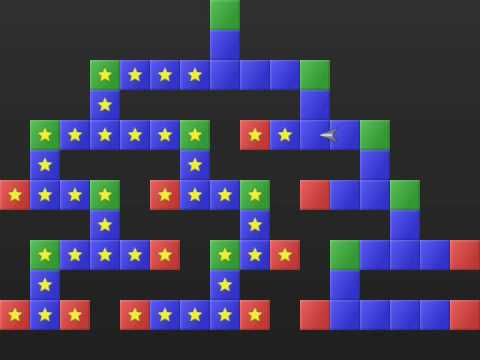

In [10]:
YouTubeVideo('MmqBVWi_Pc0', width=640, height=480)

# 1. Introduction
Robozzle is a game where the player programs a robot to pick up stars on a 16 x 12 grid. In the image below, the commands and program space (the functions) are on the right. There are 3 commands that control the movement of the robot: Forward, Left, and Right.  Commands can be grouped into functions; and for each function, there is a command to call it. A function that calls itself is merely a programmed loop, so the commands are repeated from the beginning. The commands can be conditional on color, so that the command is only executed when the condition and color of the tile match. The bot can also change the color of the tile it is on. This is called painting. There is much more to the game; but these are the basics.

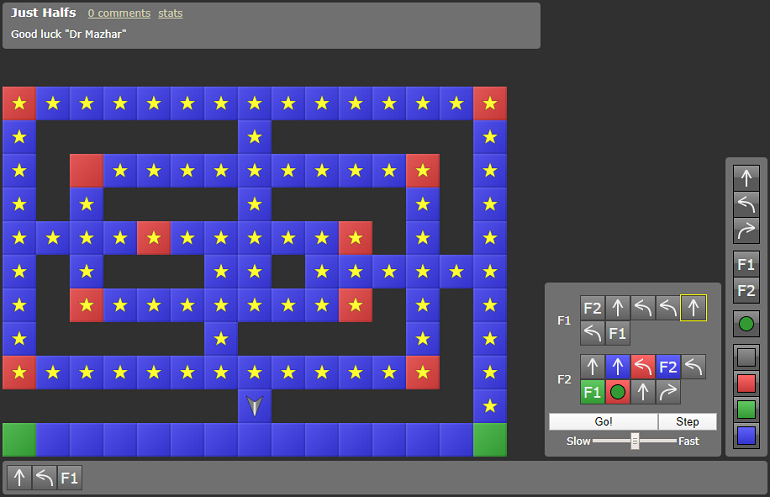

I started playing Robozzle 2.5 years ago, and have been fascinated by it ever since. It's the reason I became interested in coding, which ultimately put me on the data science path. The Robozzle website maintains a variety of player and puzzle statistics, which encourage competition among the players.  These stats are readily available to the public; and as an
avid player of the game, it made perfect sense to collect this data, and use it as the subject of my Supervised Learning Capstone.

### 2. Web Scraping Available Data and Determining a Target Variable on which to Construct a Predictive Model

To get started on this project, I needed to determine which statistics would be suitable as predictor variables, and ultimately decide on a target that these independent variables could predict with some degree of confidence. There are 2 general categories of data available on robozzle.com: puzzle data and player data. This research focuses on puzzle data. Robozzle players may vote on puzzles that they have solved. Just like YouTube videos and Facebook posts, there are 'Like' and 'Dislike' buttons for players to express their enjoyment. When a player solves a puzzle, they are immediately presented with options to vote on 2 metrics:

1. puzzle difficulty (on a 1 - 5 ordinal scale; 1 being very easy, and 5 being very difficult), and
2. enjoyment (in the form of 'Like' and 'Dislike' buttons)

It should be made clear that there are 3 distinct outcomes for this 2nd metric, two of which are obvious. First, the player can click 'Like', or second, the player can click 'Dislike'. The third outcome is that the player does not click either button. Unfortunately, there is no way to measure the player's intent (or lack thereof) in not voting. Nevertheless, since a 'Like' is a positive response, and a 'Dislike' is a negative response, we may represent these outcomes with +1 for a 'Like' and -1 for a 'Dislike'. Likewise, we may think of a player who doesn't vote as 'neutral', which we can represent with a 0. Technically, not voting would translate to a null value. However, choosing a 0 is more practical, since it allows us to perform calculations. As individual enjoyment is measured in likes and dislikes, the accumulation of this metric is often interpreted as popularity. There are many reasons why a player might like or dislike a puzzle. The primary goal of this research is to determine the factors that influence the popularity of Robozzle puzzles, and construct several models to predict a puzzle's popularity based on several explanatory variables.

Once I chose a target, I needed to collect data from robozzle.com. I decided that scraping the website would be the best way to obtain it. On http://robozzle.com/puzzles.aspx, I scraped 5 items on each puzzle: 'puzzle ID', 'title', 'author', 'difficulty', and 'liked / disliked'. I then proceeded to each puzzle's 'Stats' page to scrape 'date posted', and 'players solved'. There are just over 8600 puzzles available, with 100 puzzles listed per page in reverse chronological order, so a single iteration scraped data from two urls. This process continued to automate 100 times per page across 86 pages. After the data was scraped, I processed it for analysis by stripping and slicing strings, or converting strings to integers or floats as needed.

Using a list I created from the puzzle IDs obtained in the initial scrape, I obtained solution lengths from each puzzle's 'Stats' page.  This time, I processed the data as it was scraped, calculating the both the mean and mode of the solution lengths, and storing them as separate variables. I also obtained the length of the shortest solution (minimum solution length), and stored it as a separate variable.  Solution lengths are sorted in ascending order on the 'Stats' pages, so the first value in the list of solution lengths is the shortest.

Finally, a third scrape was performed to obtain the design parameters for each puzzle: '# functions', '# command slots', '# red tiles', '# green tiles', '# blue tiles', '# of stars', and 'paint'.  Obtaining this data required additional research, as the tools and methods for scraping JavaScript are beyond the scope of the current Thinkful data science flex curriculum. Specifically, the Selenium library's WebDriver uses Chromium's ChromeDriver to launch a browser instance from Jupyter Notebook, obtain the page source, and supply it to BeautifulSoup for parsing. (All scraping was done in a separate notebook. For convenience and grading purposes, I have included a snippet of that code below.) Once the data is scraped, the simple command `driver.close()` closes the browser. This completes one iteration. The process is automated via a `for` loop, so after 17 hours and over 8,500 iterations, the scrape is complete. As with the initial scrape, this data also needed processing to convert data types for proper analysis.

In [690]:
# For demonstration purposes, this will only scrape 3 puzzles.
# chromedriver.exe is required to run this cell without error.

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import os

# import data set assembled from previous scrape
robozzles = pd.read_csv('https://github.com/jp213/thinkful/raw/master/robozzle_06.csv')

# create list to supply scraper to fill url
id_list = list(robozzles.puzzleid[:3])

# create empty list to store dictionaries
puzzles = []

# scrape for number of tiles of each color and number of stars
for id in id_list:
    pid = id
    url = 'http://www.robozzle.com/beta/index.html?puzzle={0}'.format(pid)

    # create Chrome session
    driver = webdriver.Chrome(executable_path=r"C:\Users\jnpol\Documents\DS\Data Science\Mod_25\chromedriver.exe")
    driver.implicitly_wait(30)
    driver.get(url)

    python_button = driver.find_element_by_id('board')
    python_button.click()
    soup_level1 = BeautifulSoup(driver.page_source, 'lxml')
    tile_rows = soup_level1.find('table', class_=re.compile("^board__grid")).find_all('tr')

    red_list, green_list, blue_list, star_list = [], [], [], []

    for row in tile_rows:
        for i in range(0, 16):
            try:
                color = row.find_all('td')[i].get('class')[2]
                if color == '-color-R':
                    red_list.append(color)
                elif color == '-color-G':
                    green_list.append(color)
                elif color == '-color-B':
                    blue_list.append(color)
            except:
                pass
            try:
                star = row.find_all('td')[i].find('div').get('class')[1]
                star_list.append(star)
            except:
                pass

    puzzle = {'puzzleid': pid, 'red_list': len(red_list), 'green_list': len(green_list),
              'blue_list': len(blue_list), 'stars': len(star_list)}
    puzzles.append(puzzle)
    driver.close()

In [691]:
puzzles

[{'puzzleid': 12796,
  'red_list': 43,
  'green_list': 41,
  'blue_list': 53,
  'stars': 36},
 {'puzzleid': 12795,
  'red_list': 13,
  'green_list': 15,
  'blue_list': 108,
  'stars': 10},
 {'puzzleid': 12794,
  'red_list': 2,
  'green_list': 9,
  'blue_list': 9,
  'stars': 2}]

All scraped data was captured in Python dictionaries, converted to pandas DataFrames, saved as .csv files, and uploaded to GitHub for safe keeping. With the scraping complete, I then imported the data to Jupyter Notebook. Before we dive into the data, let's formulate a research question.

# Research Questions with Formal Hypothesis

Given the available statistics, how well can we:
1. Explain the variance in the popularity of RoboZZle puzzles?
2. Predict the popularity of a RoboZZle puzzle?

### Null Hypothesis

There is no relationship between the feature set (independent variables) and a puzzle's popularity (dependent/target variable).

### Alternative Hypothesis

At least one of the independent variables is useful in explaining or predicting a puzzle's popularity.

In [19]:
robozzle = pd.read_csv('https://github.com/jp213/thinkful/raw/master/robozzle_06.csv')
fns_and_paint = pd.read_csv('https://github.com/jp213/thinkful/raw/master/fns_and_paint.csv')
colors_and_stars = pd.read_csv('https://github.com/jp213/thinkful/raw/master/colors_and_stars.csv')
val = {'title': 'unnamed', 'author': 'unknown'}
robozzle = robozzle.fillna(value=val)
robozzle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   puzzleid        8603 non-null   int64  
 1   date_posted     8603 non-null   object 
 2   title           8603 non-null   object 
 3   author          8603 non-null   object 
 4   difficulty      8603 non-null   float64
 5   players_solved  8603 non-null   int64  
 6   mean_sol_len    8603 non-null   float64
 7   mode_sol_len    8603 non-null   int64  
 8   min_sol_len     8603 non-null   int64  
 9   likes           8603 non-null   int64  
 10  dislikes        8603 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 739.4+ KB


# 3. EDA

Before diving into the data, it should be noted that in general, Robozzle was substantially more popular when the website was initially launched; but the game's popularity has faded with time. Expectations for model fits and predictive power must take this into consideration, since each observation in this data set contains its own sample size - the number of players who solved the puzzle. Smaller sample sizes result in greater variance, regardless of the popularity metric chosen. This will be later demonstrated in model performance metrics.

A quick glance at the data reveals variables which are mostly numeric, along with two categoricals, and a datetime. These were mentioned briefly above in the section on web scraping.  Here is a recap of those variables, along with a brief description, and a look at the head of each DataFrame assembled from web scraping:

- puzzleid (int) - Each puzzle has a unique identification number. There are many gaps between observations, some of them quite large. Since this variable will not be selected as a feature, this warrants no further investigation. (I have communicated with Igor Ostrovsky, the creator of RoboZZle, on multiple occasions; yet I never thought to ask him about this.)
- difficulty (float) - When a player solves a puzzle, that player may select a number from 1 (very easy) to 5 (very hard) to vote on the puzzle's difficulty.  The mean of players's difficulty votes for each puzzle is posted as it's difficulty.
- players_solved (int) - number of players that have solved each puzzle.
- mean_sol_len (float) - mean solution length, as displayed on each puzzle's 'Stats' page.
- mode_sol_len (int) - the most frequently occurring solution length (if not multimodal), displayed on each puzzle's 'Stats' page. For this research, puzzles with more than 1 mode are given assigned a value of 0.
- min_sol_len (int) - minimum solution length, as indicated by the first solution length listed on each puzzle's 'Stats' page.
- likes (int) - the number of like votes for each puzzle.
- dislikes (int) - the number of dislike votes for each puzzle.
- functions (int) - the number of functions available in each puzzle; ranges from 1 - 5.
- commands (int) - the number of command slots available for each puzzle, also the sum of the lengths of the functions; ranges from 1 - 50 (not to be confused with command *types* like movement commands, function calls, and paint commands).
- paint (int/bool) - whether (1) or not (0) paint can be used to solve a puzzle (chosen by the puzzle designer).
- red_tiles (int) - the number of red tiles in a puzzle.
- green_tiles (int) - the number of green tiles in a puzzle.
- blue_tiles (int) - the number of blue tiles in a puzzle.
- stars (int) - the number of stars in a puzzle; the number of stars that the bot must collect in order to solve the puzzle.

In [22]:
display(robozzle.head())
display(fns_and_paint.head())
colors_and_stars.head()

,puzzleid,date_posted,title,author,difficulty,players_solved,mean_sol_len,mode_sol_len,min_sol_len,likes,dislikes
0,12796,3/31/2020 8:30:11 PM,XOR Lines,scorpio,3.00,3,19.000000,20,17,2,0
1,12795,3/31/2020 12:06:12 PM,Bushnell's Law,axorion,3.80,6,29.333333,0,25,5,0
2,12794,3/30/2020 3:03:31 PM,Test,MrMartin,1.75,12,9.166667,8,6,4,1
3,12793,3/27/2020 3:28:42 PM,tbh i dont know???,LACav,1.86,12,23.500000,14,14,4,1
4,12792,3/27/2020 12:21:23 PM,Just Halfs,drmazhar,3.20,7,15.714286,16,15,5,0


,puzzleid,functions,function_lengths,paint
0,12796,4,"['-sublen5', '-sublen10', '-sublen5', '-sublen5']",[0]
1,12795,5,"['-sublen10', '-sublen5', '-sublen10', '-suble...",[0]
2,12794,4,"['-sublen10', '-sublen3', '-sublen3', '-sublen2']",[1]
3,12793,5,"['-sublen10', '-sublen10', '-sublen10', '-subl...",[0]
4,12792,2,"['-sublen7', '-sublen9']",[1]


,puzzleid,red_list,green_list,blue_list,stars
0,12796,43,41,53,36
1,12795,13,15,108,10
2,12794,2,9,9,2
3,12793,42,3,42,18
4,12792,11,1,94,104


The 'function_lengths' and 'paint' variables in the middle DataFrame above are in need of processing. The following code manipulates the data using a variety of techniques (slicing based on finding delimiters, slicing based on index position, creating a pandas Series in order to implement a string processing method, converting to numeric, and summing the elements in a Series) to accomplish the tasks.

In [41]:
fns_and_paint['has_paint'] = np.nan
fns_and_paint['commands'] = 0
fns_and_paint['f_lengths'] = fns_and_paint.function_lengths
fns_and_paint.f_lengths = fns_and_paint.f_lengths.apply(literal_eval)

for i in range(0, 8603):
    test_str = fns_and_paint.paint[i]
    str_str = test_str[test_str.find('[') + 1 : test_str.find(']')]
    fns_and_paint.loc[[i], 'has_paint'] = str_str

    ts = pd.Series(fns_and_paint.f_lengths[i])
    ts2 = pd.to_numeric(ts.str.slice(start=7))
    fns_and_paint.commands[i] = ts2.sum()

The 'date_posted' variable began as a string, and includes the date and time that each puzzle was posted. The string was converted to datetime. This was then transformed into a 'day_posted' (int) variable which set the day that the first puzzle was posted equal to 1, and set the values for all other puzzles relative to the first, adding the number of days since day 1. See below.

In [23]:
robozzle['datetime_posted'] = pd.to_datetime(robozzle.date_posted)
robozzle['year'] = 0
robozzle['month'] = 0
robozzle['day'] = 0
robozzle['yearindays'] = 0
robozzle['monthindays'] = 0
robozzle['day_posted'] = 0

for i in range(0, 8603):
    year = pd.DatetimeIndex(robozzle['datetime_posted']).year[i]
    robozzle.year[i] = year
    month = pd.DatetimeIndex(robozzle['datetime_posted']).month[i]
    robozzle.month[i] = month
    day = pd.DatetimeIndex(robozzle['datetime_posted']).day[i]
    robozzle.day[i] = day

robozzle.year = robozzle.year - 2008

for i in range(0, 8603):
    x = robozzle.year[i]
    ytd = 365 * x 
    if robozzle.year[i] > 4:
        ytd += 1
    if robozzle.year[i] > 8:
        ytd += 1
    robozzle.yearindays[i] = ytd

for i in range(0, 8603):
    x = robozzle.month[i]
    days = 0
    if x > 1:
        days = 31
    if x > 2:
        if robozzle.year[i] % 4 == 0:
            days += 29
        else:
            days += 28
    if x > 3:
        days += 31
    if x > 4:
        days += 30
    if x > 5:
        days += 31
    if x > 6:
        days += 30
    if x > 7:
        days += 31
    if x > 8:
        days += 31
    if x > 9:
        days += 30
    if x > 10:
        days += 31
    if x > 11:
        days += 30
    robozzle.monthindays[i] = days

for i in range(0, 8603):
    robozzle['day_posted'][i] = robozzle.yearindays[i] + robozzle.monthindays[i] + robozzle.day[i]

robozzle.day_posted = robozzle.day_posted - 349
robozzle.day_posted = robozzle.day_posted.replace(1, 65)
robozzle.day_posted = robozzle.day_posted.replace(2, 66)
robozzle.day_posted = robozzle.day_posted - 64
robozzle['day_posted_yj'],_ = yj(robozzle.day_posted)
robozzle.drop(['date_posted', 'title', 'datetime_posted', 'year', 'month', 'day',
               'yearindays', 'monthindays', 'day_posted'], 1, inplace=True)

The categorical variables are 'title' and 'author'. There are certainly methods to analyze strings to determine if a puzzle's title has any power in explaining variance or in predicting popularity; but as both a top 10 player, and top 2 designer, I am familiar with the extensive liberties taken in naming a creation. I do not claim or even assume that there is no correlation between a puzzle title and its popularity; but rather chose to discard this variabe and proceed under the assumption that a puzzle's author will likely be a stronger feature. However, the author variable is distributed quite peculiarly. There are over 1,500 authors that account for the roughly 8,600 puzzles. The two most prolific designers have authored 708, and 652 puzzles, respectively. The next author on the list has designed 285 puzzles.  Creating 1,500 dummy variables is impractical, so I assigned a value of 'other' to all authors with fewer than ***n*** puzzles submitted, and created dummies based on this threshold. I set this threshold to various values when evaluating model performance.

From these variables, a target variable to represent popularity must be chosen or constructed. Popularity can be defined in a number of ways. Much of this project involved experimenting with several formulations of popularity, and ultimately choosing the measure that resulted in the best model performance. Determining a suitable formula to represent popularity is not without controversy. I researched a number of possibilities for what an appropriate measure of popularity might be, based on likes and dislikes, but that would somehow take into account small sample sizes.
I ran across https://www.evanmiller.org/how-not-to-sort-by-average-rating.html, which presents two 'wrong' formulations:
- Score = (Positive ratings) − (Negative ratings); and
- Score = Average rating = (Positive ratings) / (Total ratings)

The site then presents the 'correct solution' as:
- Score = Lower bound of Wilson score confidence interval for a Bernoulli parameter

At the time, I was happy to have found something that seems entirely logical, and was hopeful that I would obtain good results using this measure. I quickly found a python implementation, and compared it with the formula presented on evanmiller.org. As a precaution, I also developed several of my own formulas for popularity, and decided that the metric that resulted in the best fits and most consistent model performance would be declared the winner. My most basic popularity formula was simply:
- (likes - dislikes)/players_solved

I initially created a variable composed of Yeo-Johnson transformations of these 3 variables. In addition, I experimented with several variables derived using various power transformations. This project was about 75% complete when I decided to try one last popularity formula:
- a single Yeo-Johnson transformation of (likes - dislikes)/players_solved

This ultimately proved to be the winner.  Since some of the popularity formulas are derived from other transformed variables, the code for these formulas will be inserted after univariate analysis.

I proceeded with standard EDA - looking at histograms of distributions and descriptive statistics for each variable. Yeo-Johnson transformations were applied to nearly all variables for the sake of normality, and to reduce the number of potential outliers for the variables. Nevertheless, outliers were detected with almost all variables. Since I collected the data, and I am intricately familiar with Robozzle statistics, I am extremely confident that the outliers are not the result of errors in the data collection process, and that they are all valid data points. With this in mind, I took a cautious approach to outliers, choosing only to apply some very minimal winsorization (at the .005 and .995 quantiles) to these variables by way of the `pandas.clip()` method.

## Univariate Analysis

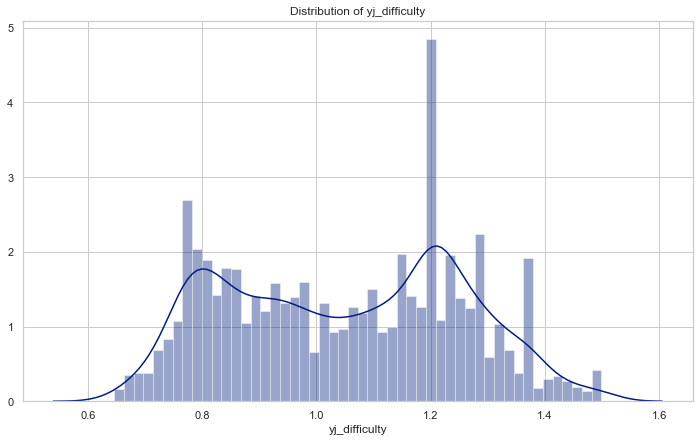

yj_difficulty: DescribeResult(nobs=8603, minmax=(0.6460615772584305, 1.4990134873405112), mean=1.049765173972519, variance=0.041988298544488954, skewness=0.020331770425690208, kurtosis=-1.1394571932001212) 

0.6716616228105189
1.4990134873405112


In [29]:
# Yeo-Johnson transform difficulty
robozzle['yj_difficulty'],_ = yj(robozzle.difficulty)
plt.figure(figsize=(12,7))
plt.title('Distribution of yj_difficulty')
ax = sns.distplot(robozzle.yj_difficulty, bins=50)
plt.show()
print('yj_difficulty stats:', stats.describe(robozzle.yj_difficulty), '\n')
print(robozzle.yj_difficulty.quantile(0.005))
print(robozzle.yj_difficulty.quantile(0.995))
robozzle.yj_difficulty = robozzle.yj_difficulty.clip(lower=0.0671662, upper=1.499)

In [30]:
# Yeo-Johnson transformations of players_solved, likes, and dislikes
# with post-transformation descriptive statistics

robozzle['yj_players_solved'],_ = yj(robozzle.players_solved)
print('yj_players_solved stats:', stats.describe(robozzle.yj_players_solved), '\n')

robozzle['yj_likes'],_ = yj(robozzle.likes)
print('yj_likes stats:', stats.describe(robozzle.yj_likes), '\n')

robozzle['yj_dislikes'],_ = yj(robozzle.dislikes)
print('yj_dislikes stats:', stats.describe(robozzle.yj_dislikes), '\n')

yj_players_solved: DescribeResult(nobs=8603, minmax=(0.657286868299326, 5.125512028106955), mean=2.7067782122126802, variance=0.6656095502092404, skewness=0.03386046875158483, kurtosis=-0.45633542965863505) 

yj_likes: DescribeResult(nobs=8603, minmax=(-0.0, 4.117516787504617), mean=1.7449398833767755, variance=0.6067782068669416, skewness=0.008784677586955945, kurtosis=-0.06746023843296367) 

yj_dislikes: DescribeResult(nobs=8603, minmax=(-0.0, 2.6500807084154125), mean=0.8648609015441079, variance=0.545820172761568, skewness=0.17148932797170463, kurtosis=-1.2905303797689427) 



In [31]:
# Yeo-Johnson transformations of mean_sol_len, mode_sol_len, and min_sol_len
# with post-transformation descriptive statistics

robozzle['yj_mean_sol_len'],_ = yj(robozzle.mean_sol_len)
print('yj_mean_sol_len stats:', stats.describe(robozzle.yj_mean_sol_len), '\n')

robozzle['yj_mode_sol_len'],_ = yj(robozzle.mode_sol_len)
print('yj_mode_sol_len stats:', stats.describe(robozzle.yj_mode_sol_len), '\n')

robozzle['yj_min_sol_len'],_ = yj(robozzle.min_sol_len)
print('yj_min_sol_len stats:', stats.describe(robozzle.yj_min_sol_len), '\n')

yj_mean_sol_len: DescribeResult(nobs=8603, minmax=(0.7007920529221493, 4.062778706216017), mean=2.568994732883032, variance=0.3386807972471841, skewness=-0.003100146510605727, kurtosis=-0.5523647700849148) 

yj_mode_sol_len: DescribeResult(nobs=8603, minmax=(0.0, 10.590248965110565), mean=4.063936656447697, variance=3.9345369154407805, skewness=-0.015901806642226186, kurtosis=0.030525276783980537) 

yj_min_sol_len: DescribeResult(nobs=8603, minmax=(0.6849969443752706, 3.5495737837734342), mean=2.2214729261705095, variance=0.22987725722324634, skewness=0.0014167655663037916, kurtosis=-0.22657207367846732) 



In [35]:
# Assessment of z-scores and outlier treatment via pandas clip() method

print('Yeo-Johnson difficulty z-scores:')
z_yj_diff = zscore(robozzle.yj_difficulty)
for threshold in np.arange(2, 3, 0.5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_yj_diff > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_yj_diff > threshold)[0]))))
print()
print('Yeo-Johnson difficulty clip thresholds:')
print(robozzle.yj_difficulty.quantile(0.005))
print(robozzle.yj_difficulty.quantile(0.995))
robozzle.yj_difficulty = robozzle.yj_difficulty.clip(lower=0.0671662, upper=1.499)
print()

print('Yeo-Johnson mean solution length z-scores:')
z_yj_meansl = zscore(robozzle.yj_mean_sol_len)
for threshold in np.arange(2, 3, 0.5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_yj_meansl > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_yj_meansl > threshold)[0]))))
print()
print('Yeo-Johnson mean solution length clip thresholds:')
print(robozzle.yj_mean_sol_len.quantile(0.005))
print(robozzle.yj_mean_sol_len.quantile(0.995))
robozzle.yj_mean_sol_len = robozzle.yj_mean_sol_len.clip(lower=1.088, upper=3.81767)
print()

print('Yeo-Johnson mode solution length z-scores:')
z_yj_modesl = zscore(robozzle.yj_mode_sol_len)
for threshold in range(1, 4):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_yj_modesl > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_yj_modesl > threshold)[0]))))
print()
print('Yeo-Johnson mode solution length clip thresholds:')
print(robozzle.yj_mode_sol_len.quantile(0.075))
print(robozzle.yj_mode_sol_len.quantile(0.995))
robozzle.yj_mode_sol_len = robozzle.yj_mode_sol_len.clip(lower=None, upper=9.024)
print()

print('Yeo-Johnson min solution length z-scores:')
z_yj_minsl = zscore(robozzle.yj_min_sol_len)
for threshold in np.arange(2, 3, 0.5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_yj_minsl > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_yj_minsl > threshold)[0]))))
print()
print('Yeo-Johnson min solution length clip thresholds:')
print(robozzle.yj_min_sol_len.quantile(0.005))
print(robozzle.yj_min_sol_len.quantile(0.995))
robozzle.yj_min_sol_len = robozzle.yj_min_sol_len.clip(lower=0.685, upper=3.29555)

Yeo-Johnson difficulty z-scores:
The score threshold is: 2.0
The indices of the outliers:
(array([  25,  256,  265,  375,  597,  606, 1001, 1138, 1269, 1383, 1384,
       1422, 2427, 2823, 3087, 3420, 3835, 3887, 3889, 3950, 4009, 4026,
       4041, 4096, 4197, 4206, 4284, 4420, 4461, 4484, 4690, 4692, 4698,
       4803, 4916, 5315, 5451, 5612, 5633, 5705, 5714, 5716, 5799, 6076,
       6102, 6188, 6192, 6366, 6432, 6444, 6476, 6483, 6484, 6505, 6510,
       6542, 6662, 6740, 6773, 6853, 7011, 7053, 7142, 7187, 7191, 7298,
       7348, 7387, 7470, 7587, 7607, 7610, 7639, 7672, 7678, 7690, 7789,
       7847, 7872, 7942, 7988, 7993, 7997, 8008, 8022, 8023, 8028, 8080,
       8109, 8150, 8187, 8263, 8304, 8370, 8391, 8426, 8428, 8518],
      dtype=int64),)
Number of outliers is: 98
The score threshold is: 2.5
The indices of the outliers:
(array([], dtype=int64),)
Number of outliers is: 0

Yeo-Johnson difficulty clip thresholds:
0.6716616228105189
1.499

Yeo-Johnson mean solution length z-

### Popularity Metrics and Distributions

The lower bound of Wilson score confidence interval for a Bernoulli parameter (mentioned above) was tested on several models, but failed to perform as well as the worst of the following metrics. It was therefore discarded.

In [36]:
# Various formulas/metrics for popularity
robozzle['pop0'] = (robozzle.likes - robozzle.dislikes) / robozzle.players_solved
robozzle['yj_pop0'],_ = yj(((robozzle.likes - robozzle.dislikes) / robozzle.players_solved))
robozzle['pop1'] = np.sqrt(robozzle.yj_players_solved) * robozzle.yj_pop0
robozzle['pop2'] = np.cbrt(robozzle.yj_players_solved) * robozzle.yj_pop0
robozzle['pop3'] = np.power(robozzle.yj_players_solved, 1/5) * robozzle.yj_pop0
robozzle['pop4'] = np.power(robozzle.yj_players_solved, 1/10) * robozzle.yj_pop0

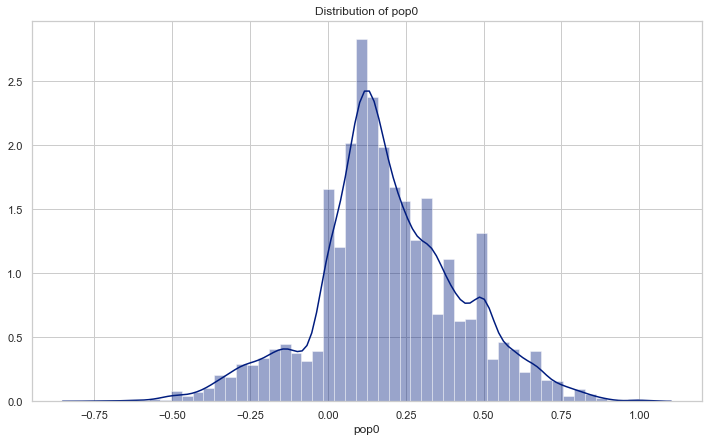

pop0: DescribeResult(nobs=8603, minmax=(-0.75, 1.0), mean=0.19311885680080476, variance=0.0543828573332972, skewness=0.015820168815524994, kurtosis=0.4584001638622168) 

pop0 z-scores:
The score threshold is: 2.5
The indices of the outliers:
(array([   1,   50,  114,  117,  253,  312,  349,  422,  431,  456,  461,
        470,  472,  564,  596,  614,  615,  619,  848,  867,  933,  963,
       1238, 2185, 3132, 3983, 4030, 4231, 4322, 4466, 4504, 4522, 4558,
       4564, 4699, 4709, 4728, 4738, 4767, 4771, 4773, 4779, 4805, 4944,
       5526, 5589, 5675, 5806, 6142, 6174, 6432, 6444, 6493, 6510, 6527,
       6528, 6616, 7097, 7155, 7208, 7396, 7402, 7610, 7672, 7690, 7740,
       7741, 7818, 8205, 8287, 8343], dtype=int64),)
Number of outliers is: 71
The score threshold is: 3.0
The indices of the outliers:
(array([ 461,  614,  615,  619,  933, 1238, 7097, 7402], dtype=int64),)
Number of outliers is: 8

pop0 clip thresholds:
-0.4499444444444445
0.8


In [38]:
# Distribution and descriptive statistics for initial target variable, pop0
plt.figure(figsize=(12,7))
plt.title('Distribution of pop0')
ax = sns.distplot(robozzle.pop0, bins=50)
plt.show()
print('pop0 stats:', stats.describe(robozzle['pop0']), '\n')

# Assessment of z-scores and outlier treatment via pandas clip() method
print('pop0 z-scores:')
z_pop0 = zscore(robozzle.pop0)
for threshold in np.arange(2.5, 3.5, 0.5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_pop0 > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_pop0 > threshold)[0]))))
print()
print('pop0 clip thresholds:')
print(robozzle.pop0.quantile(0.005))
print(robozzle.pop0.quantile(0.995))
robozzle.pop0 = robozzle.pop0.clip(lower=-0.44993, upper=0.8)

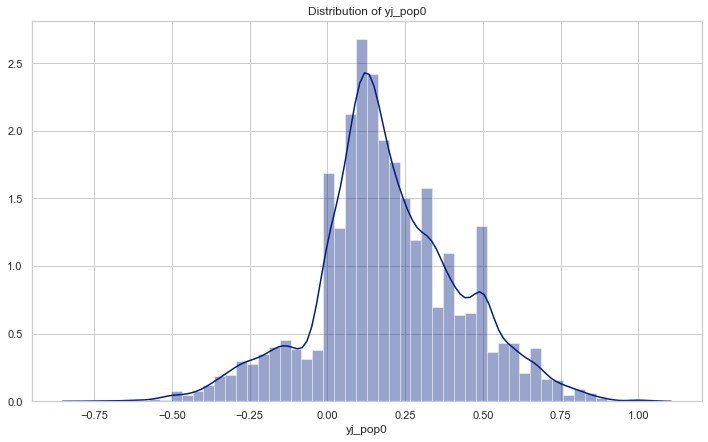

yj_pop0 stats: DescribeResult(nobs=8603, minmax=(-0.74844448311153, 1.0026280322911811), mean=0.1933911412165566, variance=0.054503532581885165, skewness=0.020616984460744, kurtosis=0.4562320501436008) 

yj_pop0 z-scores:
The score threshold is: 2.5
The indices of the outliers:
(array([   1,   50,  114,  117,  253,  312,  349,  422,  431,  456,  461,
        470,  472,  564,  596,  614,  615,  619,  848,  867,  933,  963,
       1238, 2185, 3132, 3983, 4030, 4231, 4322, 4466, 4504, 4522, 4558,
       4564, 4699, 4709, 4728, 4738, 4767, 4771, 4773, 4779, 4805, 4944,
       5526, 5589, 5675, 5806, 6142, 6174, 6432, 6444, 6493, 6510, 6527,
       6528, 6616, 7097, 7155, 7208, 7396, 7402, 7610, 7672, 7690, 7740,
       7741, 7818, 8205, 8287, 8343], dtype=int64),)
Number of outliers is: 71
The score threshold is: 3.0
The indices of the outliers:
(array([ 461,  614,  615,  619,  933, 1238, 7097, 7402], dtype=int64),)
Number of outliers is: 8

yj_pop0 clip thresholds:
-0.44934220575472755
0.

In [40]:
# Distribution and descriptive statistics for Yeo-Johnson transformed target variable, yj_pop0
plt.figure(figsize=(12,7))
plt.title('Distribution of yj_pop0')
ax = sns.distplot(robozzle.yj_pop0, bins=50)
plt.show()
print('yj_pop0 stats:', stats.describe(robozzle.yj_pop0), '\n')

# Assessment of z-scores and outlier treatment via pandas clip() method
print('yj_pop0 z-scores:')
z_yj_pop0 = zscore(robozzle.yj_pop0)
for threshold in np.arange(2.5, 3.5, 0.5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_yj_pop0 > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_yj_pop0 > threshold)[0]))))
print()
print('yj_pop0 clip thresholds:')
print(robozzle.yj_pop0.quantile(0.005))
print(robozzle.yj_pop0.quantile(0.995))
robozzle.pop0 = robozzle.yj_pop0.clip(lower=-0.449342, upper=0.80175)

At this point, the DataFrames are consolidated, and variables that are no longer needed can be dropped.

In [42]:
robozzle['functions'] = fns_and_paint.functions
robozzle['commands'] = fns_and_paint.commands
robozzle['paint'] = pd.to_numeric(fns_and_paint.has_paint)
robozzle['red_tiles'] = colors_and_stars.red_list
robozzle['green_tiles'] = colors_and_stars.green_list  
robozzle['blue_tiles'] = colors_and_stars.blue_list
robozzle['stars'] = colors_and_stars.stars
robozzle.drop(['puzzleid', 'difficulty', 'mean_sol_len', 'mode_sol_len', 'min_sol_len', 'likes',
               'dislikes', 'yj_players_solved', 'yj_likes', 'yj_dislikes'], 1, inplace=True)

## Multivariate Analysis

### Scatterplots

For multivariate analysis, I generated a few scatterplots of paired variables. For example, 'mean solution length' was plotted against the popularity metrics, and revealed a linear relationship. While the plots did not generate any straight lines, many did suggest correlations with one another. In particular, plotting difficulty against popularity provided a strong display of linearity. See the second scatterplot below.

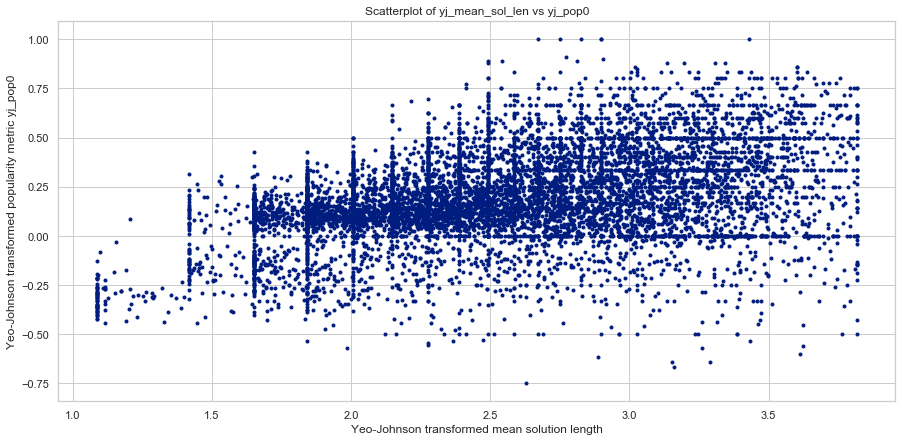

In [47]:
plt.figure(figsize=(15, 7))
plt.scatter(robozzle.yj_mean_sol_len, robozzle.yj_pop0, marker='.')
plt.title('Scatterplot of yj_mean_sol_len vs yj_pop0')
plt.xlabel('Yeo-Johnson transformed mean solution length')
plt.ylabel('Yeo-Johnson transformed popularity metric yj_pop0')
plt.show()

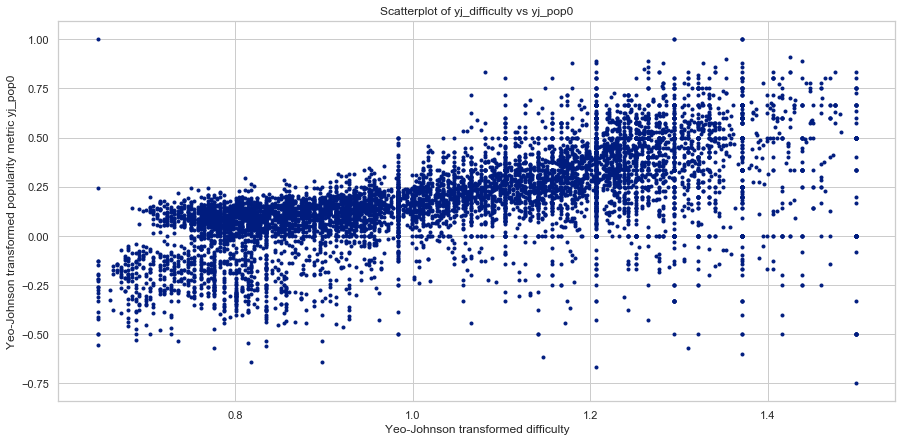

In [48]:
# yj_difficulty against yj_pop0 demonstrates an even stronger linear relationship
plt.figure(figsize=(15, 7))
plt.scatter(robozzle.yj_difficulty, robozzle.yj_pop0, marker='.')
plt.title('Scatterplot of yj_difficulty vs yj_pop0')
plt.xlabel('Yeo-Johnson transformed difficulty')
plt.ylabel('Yeo-Johnson transformed popularity metric yj_pop0')
plt.show()

## Correlation Matrix

The correlation matrix below allows for a comparison of the potential popularity metrics. In most cases, pop0 and yj_pop0 show stronger correlations to the features than the other popularity metrics (pop1, pop2, pop3, and pop4). Close examination of the matrix verifies the games' decline in popularity, showing negative coefficients when comparing puzzleid with players_solved, or day_posted with dislikes. The matrix also reveals correlations which might seem odd for those unfamiliar with the game. For example, blue tiles show a higher correlation with nearly all other variables than red and green tiles do. The reason for this is that in puzzle design, it is standard practice to use blue as the main color, and to use red and green tiles to show where the bot must turn left or right. This seems to make sense, since red and green are brighter, and are also
commonly associated with traffic lights, which serve as signals for when a driver may stop, go or turn.

In [49]:
robozzle.corr()

,players_solved,day_posted_yj,yj_difficulty,yj_mean_sol_len,yj_mode_sol_len,yj_min_sol_len,pop0,yj_pop0,pop1,pop2,pop3,pop4,functions,commands,paint,red_tiles,green_tiles,blue_tiles,stars
players_solved,1.000000,-0.220657,-0.137431,-0.165511,-0.081103,-0.163731,-0.020284,-0.020065,0.034952,0.014727,-0.000120,-0.010447,-0.143227,-0.126029,-0.061335,-0.028661,-0.028276,-0.057946,-0.060320
day_posted_yj,-0.220657,1.000000,-0.194984,0.082350,-0.023603,0.092533,-0.082576,-0.081396,-0.175718,-0.144197,-0.118930,-0.100076,0.094387,0.071857,0.026792,-0.050277,-0.060878,0.048169,0.058515
yj_difficulty,-0.137431,-0.194984,1.000000,0.560993,0.300076,0.653273,0.639317,0.635036,0.599111,0.614555,0.624465,0.630406,0.334512,0.198719,0.170001,0.027563,0.080032,0.239125,0.314794
yj_mean_sol_len,-0.165511,0.082350,0.560993,1.000000,0.536723,0.941780,0.410958,0.407522,0.355922,0.375796,0.389839,0.399205,0.772576,0.732999,0.102780,0.027395,0.047100,0.185602,0.244049
yj_mode_sol_len,-0.081103,-0.023603,0.300076,0.536723,1.000000,0.532939,0.281163,0.280012,0.272196,0.276843,0.279106,0.279935,0.367983,0.316452,0.004821,-0.012765,0.004702,0.074728,0.110140
yj_min_sol_len,-0.163731,0.092533,0.653273,0.941780,0.532939,1.000000,0.503743,0.499741,0.443709,0.465422,0.480684,0.490808,0.668850,0.567025,0.106627,-0.007291,0.015710,0.221141,0.297181
pop0,-0.020284,-0.082576,0.639317,0.410958,0.281163,0.503743,1.000000,0.999237,0.979268,0.990628,0.996374,0.998677,0.209429,0.093103,0.104891,-0.002482,0.035663,0.174478,0.258029
yj_pop0,-0.020065,-0.081396,0.635036,0.407522,0.280012,0.499741,0.999237,1.000000,0.978668,0.990433,0.996538,0.999132,0.207230,0.091988,0.105215,-0.002987,0.035952,0.173208,0.256287
pop1,0.034952,-0.175718,0.599111,0.355922,0.272196,0.443709,0.979268,0.978668,1.000000,0.997635,0.992320,0.986339,0.158563,0.042396,0.075564,-0.007278,0.035182,0.143600,0.219897
pop2,0.014727,-0.144197,0.614555,0.375796,0.276843,0.465422,0.990628,0.990433,0.997635,1.000000,0.998471,0.995312,0.176459,0.059966,0.085937,-0.005742,0.035723,0.154371,0.233368


The correlation matrix helped in narrowing down our target variable choices to pop0 and yj_pop0, so we may drop the other pop- variables, and scale the data in preparation for modeling. Note that although player_solved was used in creating the popularity metrics, it still remains in the DataFrame. It will not be scaled, and will be used only as a filter during the modeling process.

In [51]:
robozzle.drop(['pop1', 'pop2', 'pop3', 'pop4'], 1, inplace=True)
robozzle[['day_posted_yj', 'yj_difficulty', 'yj_mean_sol_len', 'yj_min_sol_len', 'yj_mode_sol_len', 'pop0', 'yj_pop0', 'functions', 'commands', 'red_tiles', 'blue_tiles', 'stars']] = scaler.fit_transform(robozzle[['day_posted_yj', 'yj_difficulty', 'yj_mean_sol_len', 'yj_min_sol_len', 'yj_mode_sol_len', 'pop0', 'yj_pop0', 'functions', 'commands', 'red_tiles', 'blue_tiles', 'stars']])

# Formal Hypothesis Test

We will choose my favorite variable yj_min_sol_len to determine if it has any explanatory power for the target.
(This variable carries sentimental value, since I rank 2nd in Shortest Solutions!)

Coefficients: 
 [0.50323958]
Mean squared error: 0.03
Coefficient of determination: 0.26


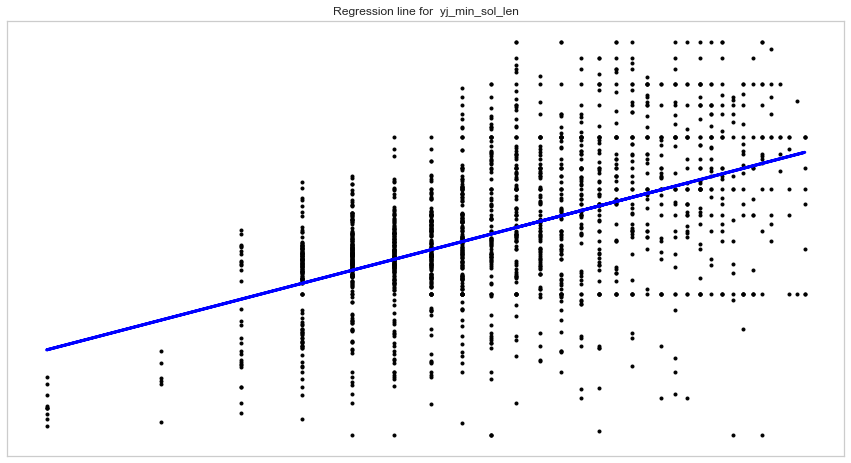

In [763]:
rob_array = robozzle.to_numpy()
X = rob_array[:, np.newaxis, 6]
Y = robozzle.pop0
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)
lrm = LinearRegression()
lrm.fit(x_train, y_train)
# Making predictions
y_preds_train = lrm.predict(x_train)
y_preds_test = lrm.predict(x_test)

print('Coefficients: \n', lrm.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_preds_test))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_preds_test))

# Plot outputs
plt.figure(figsize=(15, 8))
plt.scatter(x_test, y_test, marker='.', color='black')
plt.plot(x_test, y_preds_test, color='blue', linewidth=3)
plt.title('Regression line for  yj_min_sol_len')
plt.xticks(())
plt.yticks(())
plt.show()

### Rejection

The linearity is not quite as strong when yj_difficulty is the dependent variable. Nevertheless, the slope is not 0, so we reject the null hypothesis.

# Models

### Preliminary Tests

With EDA complete (let's not kid ourselves; EDA is never really complete), it's time to begin the modeling phase. Now that the variables are scaled, several models will be employed to fit, train, and test. I used statsmodels' OLS algorithm and scikit-learn's LinearRegression for preliminary tests. There are 3 goals of these preliminary tests:
1. Determine a fixed upper limit placed on players_solved
2. Find the optimum threshold for whether an author value should be converted to a dummy variable or grouped with other authors under that threshold and reassigned the value "other".
3. Determine which of the 2 popularity metrics will be chosen for full modeling.

For the first task, I tested the following thresholds using a Linear Regression model:

1. no upper threshold on players_solved
2. players_solved < 14,500 (removes top 5 most solved puzzles)
3. players_solved < 10,000 (removes top 14 most solved puzzles)
4. players_solved < 5,000 (removes top 36 most solved puzzles)
5. players_solved < 2,000 (removes top 107 most solved puzzles)
6. players_solved < 1,000 (removes top 272 most solved puzzles)

In a while loop, I placed one of the above upper thresholds along with a lower threshold set to `players_solved > 0`, increasing this lower threshold by 1 with each loop iteration. The while loop terminates when this lower threshold filters out more than half of the data set. Here is a snippet, with all of the model training, testing, and scoring code removed:

    i = 0
    frac_dataset = 1
    while frac_dataset > 0.5:

    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    frac_dataset = len(X)/8603
    i += 1

For each of these upper thresholds, I averaged the iterated results of the 10-fold cross-validated mean squared error (MSE) scores. Setting the upper limit at 14,500 produced the lowest average MSE, so this threshold will be used for all modeling.

Next we will find the optimum threshold for author counts, which will determine the number of dummy variables created, and in turn, the size of the feature set.

In [771]:
rob_frac_features.columns

Index(['day_posted_yj', 'yj_difficulty', 'yj_mean_sol_len', 'yj_mode_sol_len',
       'yj_min_sol_len', 'functions', 'commands', 'paint', 'red_tiles',
       'green_tiles',
       ...
       'author_thenick22', 'author_timotheeee', 'author_timthree',
       'author_unknown', 'author_vvzjnp', 'author_wallacoloo', 'author_welter',
       'author_wongman', 'author_yaxlat', 'author_zero'],
      dtype='object', length=133)

In [648]:
# Linear Regression to find optimum threshold for author counts
# This cell takes a few minutes to run, so if you would like to view progress,
# uncomment the 2nd to last line in this cell.

ps0 = []
a = 100

while a > 5:
    i = 0
    r2_list, mse_list = [], []
    for i in range (0, 20):
        rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
        rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < a]).index), 'author'] = 'other'
        rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
        rob = pd.concat([rob_std, rob_dums], axis=1)

        rob_frac = rob.sample(frac=1)
        rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
        rob_frac_features.reset_index(drop=True, inplace=True)
        rob_frac.reset_index(drop=True, inplace=True)

        X = rob_frac_features
        Y = rob_frac.yj_pop0
        X = sm.add_constant(X)
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

        lrm = LinearRegression()
        lrm.fit(x_train, y_train)
        # Making predictions
        y_preds_train = lrm.predict(x_train)
        y_preds_test = lrm.predict(x_test)

        cv_scores = cross_val_score(lrm, X, Y, cv=10)
        mean_cv = np.mean(cv_scores)
        mse_cv_scores = cross_val_score(lrm, X, Y, scoring='neg_mean_squared_error', cv=10)
        mean_mse = np.abs(np.mean(mse_cv_scores))
        frac_dataset = len(X)/8603
        per_data = frac_dataset * 100
        r2_list.append(mean_cv)
        mse_list.append(mean_mse)
        i += 1
        
    r2_mean = np.mean(r2_list)
    mse_mean = np.mean(mse_list)
    model = {'model': 'linear', 'variable': 'yj_pop0', 'author_th': a, 'mean_r2': r2_mean, 'mean_mse': mse_mean}
    ps0.append(model)
#     print('auth_counts < {} is complete'.format(a)) 
    a -= 1

auth_counts < 100 is complete
auth_counts < 99 is complete
auth_counts < 98 is complete
auth_counts < 97 is complete
auth_counts < 96 is complete
auth_counts < 95 is complete
auth_counts < 94 is complete
auth_counts < 93 is complete
auth_counts < 92 is complete
auth_counts < 91 is complete
auth_counts < 90 is complete
auth_counts < 89 is complete
auth_counts < 88 is complete
auth_counts < 87 is complete
auth_counts < 86 is complete
auth_counts < 85 is complete
auth_counts < 84 is complete
auth_counts < 83 is complete
auth_counts < 82 is complete
auth_counts < 81 is complete
auth_counts < 80 is complete
auth_counts < 79 is complete
auth_counts < 78 is complete
auth_counts < 77 is complete
auth_counts < 76 is complete
auth_counts < 75 is complete
auth_counts < 74 is complete
auth_counts < 73 is complete
auth_counts < 72 is complete
auth_counts < 71 is complete
auth_counts < 70 is complete
auth_counts < 69 is complete
auth_counts < 68 is complete
auth_counts < 67 is complete
auth_counts <

In [769]:
auth_test_all = pd.DataFrame(ps0)
auth_test_all

,model,variable,author_th,mean_r2,mean_mse
0,linear,yj_pop0,100,0.557046,0.006511
1,linear,yj_pop0,99,0.557111,0.006511
2,linear,yj_pop0,98,0.557407,0.006508
3,linear,yj_pop0,97,0.557177,0.006509
4,linear,yj_pop0,96,0.557268,0.006506
...,...,...,...,...,...
90,linear,yj_pop0,10,0.578887,0.006185
91,linear,yj_pop0,9,0.581314,0.006149
92,linear,yj_pop0,8,0.580903,0.006157
93,linear,yj_pop0,7,0.581518,0.006147


Text(0, 0.5, 'mean squared error averages')

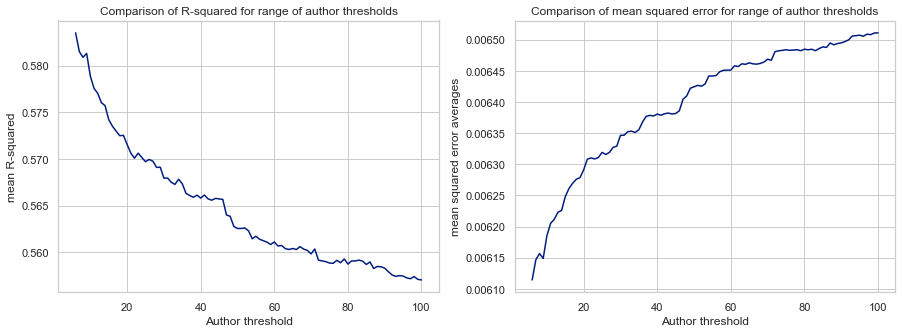

In [657]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(auth_test_all.author_th, auth_test_all.mean_r2)
plt.title('Comparison of R-squared for range of author thresholds')
plt.xlabel('Author threshold')
plt.ylabel('mean R-squared')

plt.subplot(1, 2, 2)
plt.title('Comparison of mean squared error for range of author thresholds')
v1 = plt.plot(auth_test_all.author_th, auth_test_all.mean_mse)
plt.xlabel('Author threshold')
plt.ylabel('mean squared error averages')

plt.show()

The plots above show clearly that as the threshold for the number of puzzles required for individual authors to be represented with a dummy variable increases, R-squared decreases, and MSE increases. Therefore, this threshold will be fixed at 6 for all model testing. This will produce 212 dummy variables. Lowering the threshold any further would cause rapid expansion of the feature set, as demonstrated below.

In [676]:
author_counts = robozzle.author.value_counts()
i = 7
while i > 0:
    num_dummies = len(author_counts[author_counts >= i])
    print('Setting the threshold at {} would result in {} dummy variables.'.format(i, num_dummies))
    i -= 1

Setting the threshold at 7 would result in 156 dummy variables.
Setting the threshold at 6 would result in 212 dummy variables.
Setting the threshold at 5 would result in 356 dummy variables.
Setting the threshold at 4 would result in 454 dummy variables.
Setting the threshold at 3 would result in 576 dummy variables.
Setting the threshold at 2 would result in 830 dummy variables.
Setting the threshold at 1 would result in 1516 dummy variables.


### Choosing the Popularity Metric

To determine the best metric for popularity, I again used linear regression to test each variable, starting with the lower threshold on `players_solved > 0`, and increasing it by 1 on each iteration of a while loop which terminates when the players_solved threshold filters more than half of the data. Python dictionaries capture the metrics, then DataFrames are created for further analysis.

In [693]:
# Linear OLS: Run once with popularity metric pop0, then again with yj_pop0, then compare.
# Graders, please read carefully for best results.

lr_var1 = [] # change this variable name when changing variables so that the first variable's results are not overwritten.
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.pop0 # change the pupularity variable here, and rename in the dictionary below.
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    lrm = LinearRegression()
    lrm.fit(x_train, y_train)
    # Making predictions
    y_preds_train = lrm.predict(x_train)
    y_preds_test = lrm.predict(x_test)

    cv_scores = cross_val_score(lrm, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(lrm, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'linear', 'variable': 'pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    lr_var1.append(model) # Make sure the name of this variable matches the one declared at the top of this cell.

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.49923661 0.48710732 0.49529302 0.46821546 0.5107965  0.48827742
 0.42772656 0.50935693 0.50288579 0.45333224]
Mean cross validation score: 0.48422
MSE scores for the 10 folds:  [-0.00830956 -0.00968264 -0.00977682 -0.00944632 -0.00859706 -0.0093089
 -0.01018586 -0.00814779 -0.0083775  -0.00984512]
MSE mean cross validation score: 0.00917

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.52034746 0.41944329 0.48325466 0.45272835 0.44734881 0.526705
 0.52172096 0.49733375 0.46813852 0.50850467]
Mean cross validation score: 0.48455
MSE scores for the 10 folds:  [-0.00833645 -0.0104821  -0.00997323 -0.00897267 -0.00951661 -0.00875139
 -0.00809743 -0.00978233 -0.00895044 -0.00828519]
MSE mean cross validation score: 0.00911

For players_solved > 2, there are 8381 samples.
Modelin

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.61036649 0.61217517 0.63712115 0.59716851 0.60851058 0.65226379
 0.61257172 0.60856435 0.64614349 0.6032174 ]
Mean cross validation score: 0.61881
MSE scores for the 10 folds:  [-0.00468248 -0.00462146 -0.00436058 -0.00459471 -0.0041892  -0.00431113
 -0.00466449 -0.0047102  -0.00453229 -0.00455673]
MSE mean cross validation score: 0.00452

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.57617186 0.61042786 0.63094059 0.59065569 0.60010244 0.64753127
 0.59527345 0.64807553 0.62281597 0.62405161]
Mean cross validation score: 0.61460
MSE scores for the 10 folds:  [-0.00559347 -0.00417768 -0.00417789 -0.00436165 -0.00430371 -0.00448018
 -0.00444018 -0.0041702  -0.0043872  -0.00478187]
MSE mean cross validation score: 0.00449

For players_solved > 20, there are 5484 samples.
M

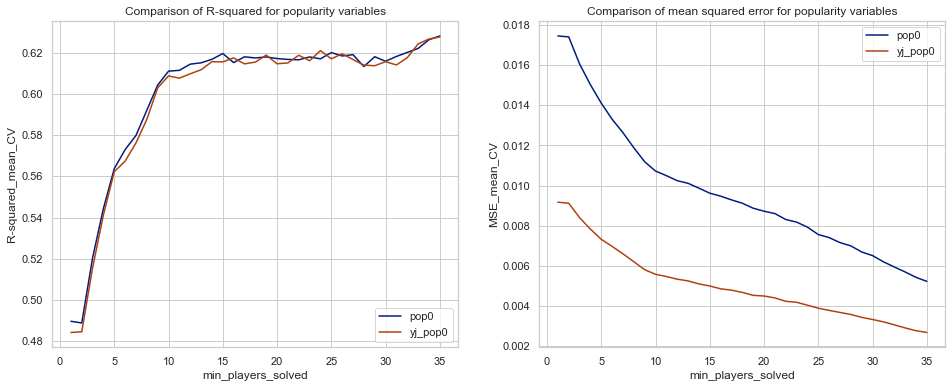

In [698]:
var1, var2 = pd.DataFrame(lr_var1), pd.DataFrame(lr_var2)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
v1r2 = plt.plot(var1.min_players_solved, var1['R-squared_mean_CV'], label='pop0')
v2r2 = plt.plot(var1.min_players_solved, var2['R-squared_mean_CV'], label='yj_pop0')
plt.title('Comparison of R-squared for popularity variables')
plt.xlabel('min_players_solved')
plt.ylabel('R-squared_mean_CV')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.title('Comparison of mean squared error for popularity variables')
v1mse = plt.plot(var1.min_players_solved, var1['MSE_mean_CV'], label='pop0')
v2mse = plt.plot(var1.min_players_solved, var2['MSE_mean_CV'], label='yj_pop0')
plt.xlabel('min_players_solved')
plt.ylabel('MSE_mean_CV')
plt.legend(loc='upper right')
plt.show()

The plots above indicate that the results are comparable for R-squared; but the Yeo-Johnson transformed variable is clearly the better performer with mean squared error. These plots also demonstrate the benefit of adequate sample sizes in any statistical analysis. As the number of players that solve a puzzle (sample size) increases, the number of votes (likes/dislikes) increases, and any measure of popularity will be more representative of the population. With that said, we will move forward modeling with the Yeo-Johnson transformed `yj_pop0` as our target variable.

## Testing Assorted Models

A variety of sci-kit learn models were employed for this research, most of which are demonstrated below. K-Nearest Neighbors regression was briefly used to assess models consisting of features selected via PCA; but was incapable of handling larger feature sets. The unique distribution of the 'author' variable necessitated a large feature set, and this model simply wouldn't suffice. For this reason, the KNN models are not included here. Results for Linear Regression have already been obtained above, and will be included in comparison with the models below.

### Ridge Regression

In [699]:
# Ridge

ridge_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    rid = Ridge()
    rid.fit(x_train, y_train)
    # Making predictions
    y_preds_train = rid.predict(x_train)
    y_preds_test = rid.predict(x_test)
    
    cv_scores = cross_val_score(rid, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(rid, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'ridge', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    ridge_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.47503066 0.54547493 0.47264026 0.48583571 0.50427716 0.43892665
 0.44662245 0.49647918 0.51944569 0.47721067]
Mean cross validation score: 0.48619
MSE scores for the 10 folds:  [-0.00890926 -0.00771909 -0.00972607 -0.00869544 -0.00896224 -0.01049831
 -0.00985421 -0.00850433 -0.00918972 -0.00924911]
MSE mean cross validation score: 0.00913

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.50327434 0.49257689 0.49779895 0.51457429 0.48886301 0.47631371
 0.45561853 0.45870647 0.46271621 0.52122306]
Mean cross validation score: 0.48717
MSE scores for the 10 folds:  [-0.00930457 -0.00843233 -0.0095908  -0.00867545 -0.00902369 -0.00953211
 -0.00863828 -0.00974246 -0.00917204 -0.0085928 ]
MSE mean cross validation score: 0.00907

For players_solved > 2, there are 8381 samples.
Mode

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.59394157 0.62577208 0.63711854 0.65573405 0.57802733 0.57352713
 0.65960523 0.62986502 0.58909461 0.64062502]
Mean cross validation score: 0.61833
MSE scores for the 10 folds:  [-0.00505204 -0.00428754 -0.00507196 -0.00456774 -0.00454887 -0.00473199
 -0.00392066 -0.00397224 -0.00492116 -0.0041957 ]
MSE mean cross validation score: 0.00453

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.59362549 0.60190782 0.61745693 0.60859774 0.60966406 0.65089742
 0.6047408  0.63252903 0.61948051 0.643587  ]
Mean cross validation score: 0.61825
MSE scores for the 10 folds:  [-0.0045962  -0.00474053 -0.00399407 -0.00404076 -0.00451628 -0.00446426
 -0.00544812 -0.00423436 -0.00439438 -0.00406576]
MSE mean cross validation score: 0.00445

For players_solved > 20, there are 5484 samples.
M

## Bayesian Ridge

In [700]:
# Bayesian Ridge

bayesian_ridge_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    brr = BayesianRidge()
    brr.fit(x_train, y_train)
    # Making predictions
    y_preds_train = brr.predict(x_train)
    y_preds_test = brr.predict(x_test)
    
    cv_scores = cross_val_score(brr, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(brr, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'bayesian_ridge', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    bayesian_ridge_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.54227675 0.49080769 0.48464191 0.48160699 0.47743197 0.45629551
 0.48668216 0.5265542  0.46631293 0.46189182]
Mean cross validation score: 0.48745
MSE scores for the 10 folds:  [-0.00876329 -0.00930551 -0.00854477 -0.00891019 -0.01031847 -0.0095843
 -0.00897468 -0.00757804 -0.01019974 -0.00881003]
MSE mean cross validation score: 0.00910

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.42214118 0.46516804 0.50795487 0.49263446 0.54205222 0.4873934
 0.52305642 0.45291508 0.49562845 0.48155922]
Mean cross validation score: 0.48705
MSE scores for the 10 folds:  [-0.00982177 -0.00816489 -0.00854655 -0.00872437 -0.00803983 -0.00973908
 -0.00892217 -0.0102847  -0.00960365 -0.00880787]
MSE mean cross validation score: 0.00907

For players_solved > 2, there are 8381 samples.
Modeli

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.61909152 0.62794077 0.60139537 0.61502186 0.62031005 0.62172558
 0.63488263 0.60307202 0.64140282 0.62463462]
Mean cross validation score: 0.62095
MSE scores for the 10 folds:  [-0.00456553 -0.00438575 -0.00513563 -0.00475269 -0.00447946 -0.00497962
 -0.0042869  -0.00473752 -0.00403512 -0.00372806]
MSE mean cross validation score: 0.00451

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.60786243 0.62371601 0.64680442 0.63892299 0.63450918 0.60876095
 0.63208933 0.57247267 0.62839073 0.60793677]
Mean cross validation score: 0.62015
MSE scores for the 10 folds:  [-0.00489792 -0.00457631 -0.00414675 -0.00446026 -0.00444377 -0.0042711
 -0.0043262  -0.00452622 -0.00397782 -0.00461365]
MSE mean cross validation score: 0.00442

For players_solved > 20, there are 5484 samples.
Mo

## Nu Support Vector Regression

In [701]:
# NuSVR

nusvr_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    nsv = NuSVR()
    nsv.fit(x_train, y_train)
    # Making predictions
    y_preds_train = nsv.predict(x_train)
    y_preds_test = nsv.predict(x_test)
    
    cv_scores = cross_val_score(nsv, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(nsv, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'nusvr', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    nusvr_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.47348774 0.46919768 0.48174571 0.44167023 0.3838116  0.40463843
 0.47051645 0.45350793 0.44085294 0.45262391]
Mean cross validation score: 0.44721
MSE scores for the 10 folds:  [-0.00865181 -0.00965958 -0.00926764 -0.01012542 -0.01138737 -0.0109952
 -0.00898881 -0.01008157 -0.00996432 -0.00917432]
MSE mean cross validation score: 0.00983

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.44449811 0.455854   0.40582547 0.39799756 0.46352195 0.40258566
 0.43701745 0.48685291 0.47846626 0.48114659]
Mean cross validation score: 0.44538
MSE scores for the 10 folds:  [-0.00916822 -0.00932382 -0.00970935 -0.01007814 -0.00942778 -0.01251561
 -0.00940778 -0.00874519 -0.01051837 -0.00912398]
MSE mean cross validation score: 0.00980

For players_solved > 2, there are 8381 samples.
Model

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.53701059 0.55262618 0.56388889 0.54407736 0.55329687 0.56356256
 0.53600028 0.5207505  0.55101027 0.55596554]
Mean cross validation score: 0.54782
MSE scores for the 10 folds:  [-0.0049585  -0.0055401  -0.00512976 -0.00498711 -0.00583255 -0.00526509
 -0.00537277 -0.00537763 -0.00553005 -0.00569621]
MSE mean cross validation score: 0.00537

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.53378217 0.54347124 0.52546678 0.55471656 0.5717692  0.55772293
 0.55089462 0.55886409 0.5100413  0.57051122]
Mean cross validation score: 0.54772
MSE scores for the 10 folds:  [-0.00588244 -0.00542759 -0.00558679 -0.00554338 -0.00479494 -0.00464311
 -0.00494079 -0.0051307  -0.00574733 -0.00505069]
MSE mean cross validation score: 0.00527

For players_solved > 20, there are 5484 samples.
M

## Orthogonal Matching Pursuit

In [702]:
# Orthogonal Matching Pursuit

omp_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    om = omp()
    om.fit(x_train, y_train)
    # Making predictions
    y_preds_train = om.predict(x_train)
    y_preds_test = om.predict(x_test)
    
    cv_scores = cross_val_score(om, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(om, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'omp', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    omp_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.47004805 0.44817488 0.44474741 0.45328931 0.50262978 0.48546665
 0.48171327 0.42577056 0.4425733  0.48331761]
Mean cross validation score: 0.46377
MSE scores for the 10 folds:  [-0.00991851 -0.01003138 -0.0092953  -0.01012785 -0.00879651 -0.00889846
 -0.00943478 -0.00938609 -0.01004835 -0.00930348]
MSE mean cross validation score: 0.00952

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.48218176 0.46832681 0.47135529 0.42983629 0.45841097 0.41926129
 0.42797938 0.4420963  0.50293943 0.50395682]
Mean cross validation score: 0.46063
MSE scores for the 10 folds:  [-0.00908736 -0.0097011  -0.00954022 -0.01033877 -0.00971164 -0.01021509
 -0.01012081 -0.00942827 -0.00862536 -0.00866297]
MSE mean cross validation score: 0.00954

For players_solved > 2, there are 8381 samples.
Mode

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.62220808 0.59776262 0.60477558 0.60062487 0.60350251 0.56338588
 0.57300206 0.63355273 0.63176339 0.59043194]
Mean cross validation score: 0.60210
MSE scores for the 10 folds:  [-0.00421352 -0.00468476 -0.00558884 -0.00499979 -0.00465636 -0.00540661
 -0.003971   -0.00449689 -0.00437587 -0.00488548]
MSE mean cross validation score: 0.00473

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.6240059  0.57069349 0.61258316 0.59816318 0.58396497 0.58839364
 0.57514865 0.62027034 0.60058879 0.62238991]
Mean cross validation score: 0.59962
MSE scores for the 10 folds:  [-0.00429134 -0.00498967 -0.00425949 -0.00490463 -0.00452207 -0.00511003
 -0.00497141 -0.00437007 -0.00474293 -0.00449694]
MSE mean cross validation score: 0.00467

For players_solved > 20, there are 5484 samples.
M

## Gradient Boosting Regressor

In [703]:
# Gradient Boosting Regressor

gbr_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    gbr = GradientBoostingRegressor()
    gbr.fit(x_train, y_train)
    # Making predictions
    y_preds_train = gbr.predict(x_train)
    y_preds_test = gbr.predict(x_test)
    
    cv_scores = cross_val_score(gbr, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(gbr, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'gbr', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    gbr_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.52269156 0.56863791 0.59092517 0.55275263 0.53044293 0.53990746
 0.5939357  0.56124902 0.56613156 0.57027338]
Mean cross validation score: 0.55969
MSE scores for the 10 folds:  [-0.00823251 -0.00742014 -0.00754543 -0.00851465 -0.00799602 -0.00811863
 -0.00740736 -0.00728465 -0.00783498 -0.00788947]
MSE mean cross validation score: 0.00782

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.58236542 0.53479416 0.55695967 0.55956506 0.54878632 0.51711823
 0.57391597 0.56234132 0.5808901  0.57409972]
Mean cross validation score: 0.55908
MSE scores for the 10 folds:  [-0.00696474 -0.00829029 -0.0078506  -0.00815903 -0.00859935 -0.00806381
 -0.00739771 -0.00768257 -0.00776587 -0.00730485]
MSE mean cross validation score: 0.00781

For players_solved > 2, there are 8381 samples.
Mode

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.74203002 0.72562012 0.69716261 0.70418455 0.72825329 0.71822142
 0.74888361 0.73005106 0.76317451 0.75577341]
Mean cross validation score: 0.73134
MSE scores for the 10 folds:  [-0.00317006 -0.00322128 -0.00337947 -0.0036099  -0.00310838 -0.0033268
 -0.0026662  -0.00328247 -0.00306235 -0.00305142]
MSE mean cross validation score: 0.00319

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.69522104 0.76149127 0.7119824  0.73817814 0.7030934  0.74182876
 0.75003018 0.75678911 0.74816055 0.72370781]
Mean cross validation score: 0.73305
MSE scores for the 10 folds:  [-0.00342542 -0.00268205 -0.00327551 -0.00317894 -0.00319689 -0.00302699
 -0.00295171 -0.00273581 -0.00315501 -0.00337861]
MSE mean cross validation score: 0.00310

For players_solved > 20, there are 5484 samples.
Mo

## Gradient Boosting Regressor with GridSearchCV

In [708]:
# Gradient Boosting Regressor with GridSearchCV

gbrgs_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
    gbr = GradientBoostingRegressor()
    grid = GridSearchCV(estimator=gbr, param_grid=dict(alpha=alphas))
    grid.fit(X, Y)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    gbr = grid.best_estimator_
    gbr.fit(x_train, y_train)
    # Making predictions
    y_preds_train = gbr.predict(x_train)
    y_preds_test = gbr.predict(x_test)
    
    cv_scores = cross_val_score(gbr, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(gbr, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'gbrgs', 'params': grid.best_estimator_, 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    gbrgs_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.48548899 0.49134581 0.59890908 0.59074371 0.52805048 0.60141538
 0.56563235 0.55110543 0.55703191 0.60135351]
Mean cross validation score: 0.55711
MSE scores for the 10 folds:  [-0.00857856 -0.00910713 -0.00728523 -0.00635614 -0.00920535 -0.00783139
 -0.00753947 -0.00749525 -0.00794923 -0.00717636]
MSE mean cross validation score: 0.00785

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.56996294 0.5323772  0.56853291 0.55135198 0.57509027 0.5989603
 0.5625222  0.51129099 0.52931677 0.59000515]
Mean cross validation score: 0.55894
MSE scores for the 10 folds:  [-0.00783518 -0.00793951 -0.00694349 -0.00831715 -0.00769539 -0.00777511
 -0.00756006 -0.00821451 -0.00818688 -0.00736552]
MSE mean cross validation score: 0.00778

For players_solved > 2, there are 8381 samples.
Model

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.72587908 0.7668665  0.69475835 0.74285886 0.74600612 0.70676098
 0.72473195 0.72524916 0.73128255 0.75911824]
Mean cross validation score: 0.73235
MSE scores for the 10 folds:  [-0.00342074 -0.0028004  -0.00357378 -0.00287561 -0.00307551 -0.00314694
 -0.00357267 -0.00321895 -0.00332144 -0.00279226]
MSE mean cross validation score: 0.00318

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.72659952 0.72374289 0.70474292 0.72313029 0.76419515 0.7383227
 0.72132063 0.74258546 0.73938477 0.72499901]
Mean cross validation score: 0.73090
MSE scores for the 10 folds:  [-0.00308629 -0.00313193 -0.00357955 -0.00306207 -0.0027507  -0.00349708
 -0.0030741  -0.00340403 -0.00290719 -0.00281029]
MSE mean cross validation score: 0.00313

For players_solved > 20, there are 5484 samples.
Mo

## Random Forest Regressor

In [709]:
# Random Forest Regressor

rfr_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)

    rfr = RandomForestRegressor()
    rfr.fit(x_train, y_train)
    # Making predictions
    y_preds_train = rfr.predict(x_train)
    y_preds_test = rfr.predict(x_test)
    
    cv_scores = cross_val_score(rfr, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(rfr, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'rfr', 'variable': 'yj_pop0', 'min_players_solved': i, 'rows_tested': len(X),
             'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    rfr_model.append(model)

For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.52939429 0.60403291 0.52559682 0.56410924 0.61108778 0.59423372
 0.56064972 0.56260779 0.54150598 0.66015704]
Mean cross validation score: 0.57534
MSE scores for the 10 folds:  [-0.00805144 -0.00672818 -0.00902233 -0.00713084 -0.00683734 -0.00749639
 -0.0075281  -0.00751853 -0.00783313 -0.0064559 ]
MSE mean cross validation score: 0.00746

For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.5889101  0.59864244 0.59248389 0.59430206 0.56543024 0.53794307
 0.57531683 0.58882115 0.60988562 0.572415  ]
Mean cross validation score: 0.58242
MSE scores for the 10 folds:  [-0.00791455 -0.00625876 -0.00730177 -0.00680893 -0.00752922 -0.00798105
 -0.00796138 -0.00729792 -0.00657483 -0.00823685]
MSE mean cross validation score: 0.00739

For players_solved > 2, there are 8381 samples.
Mode

For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.77299107 0.7524317  0.73445097 0.78414373 0.69236762 0.74866909
 0.74530073 0.76319662 0.74347822 0.74397873]
Mean cross validation score: 0.74810
MSE scores for the 10 folds:  [-0.00283986 -0.00329908 -0.00294774 -0.00265874 -0.00340272 -0.00291585
 -0.00332372 -0.00274829 -0.00284333 -0.00286481]
MSE mean cross validation score: 0.00298

For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.74400549 0.66601977 0.77752332 0.77908974 0.71977088 0.77524264
 0.77292373 0.74968361 0.74588985 0.78201375]
Mean cross validation score: 0.75122
MSE scores for the 10 folds:  [-0.00323579 -0.00344895 -0.00265349 -0.00261758 -0.00274364 -0.00260908
 -0.00260492 -0.0029279  -0.00316178 -0.00254647]
MSE mean cross validation score: 0.00285

For players_solved > 20, there are 5484 samples.
M

## Random Forest Regressor with RandomSearchCV

In [764]:
# Random Forest Regressor with RandomSearchCV

rfrgs2_model = []
i = 0
frac_dataset = 1

while frac_dataset > 0.5:
    rob_std = robozzle[(robozzle.players_solved > i) & (robozzle.players_solved < 14500)]
    rob_std.loc[rob_std['author'].isin((rob_std['author'].value_counts()[rob_std['author'].value_counts() < 6]).index), 'author'] = 'other'
    rob_dums = pd.get_dummies(rob_std.author, prefix='author', drop_first=True)
    rob = pd.concat([rob_std, rob_dums], axis=1)
    
    rob_frac = rob.sample(frac=1)
    rob_frac_features = rob_frac.drop(['author', 'players_solved', 'pop0', 'yj_pop0'], 1)
    rob_frac_features.reset_index(drop=True, inplace=True)
    rob_frac.reset_index(drop=True, inplace=True)
    
    X = rob_frac_features
    Y = rob_frac.pop0
    X = sm.add_constant(X)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    rfr = RandomForestRegressor()
    random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
                   'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
    rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                                    n_iter=200, cv=3, verbose=2, random_state=19, n_jobs=-1)
    rfr_random.fit(X, Y)
    bp = rfr_random.best_params_
    
    X = rob_frac_features
    Y = rob_frac.yj_pop0
    X = sm.add_constant(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 19)
    
    rfr = RandomForestRegressor(**bp)
    rfr.fit(x_train, y_train)
    # Making predictions
    y_preds_train = rfr.predict(x_train)
    y_preds_test = rfr.predict(x_test)
    
    cv_scores = cross_val_score(rfr, X, Y, cv=10)
    mean_cv = np.mean(cv_scores)
    mse_cv_scores = cross_val_score(rfr, X, Y, scoring='neg_mean_squared_error', cv=10)
    mean_mse = np.abs(np.mean(mse_cv_scores))
    frac_dataset = len(X)/8603
    per_data = frac_dataset * 100
    
    print('For players_solved > {}, there are {} samples.'.format(i, len(X)))
    print('Modeling on {:.5f}% of the original dataset'.format(per_data))
    print('Accuracy scores for the 10 folds: ', cv_scores)
    print('Mean cross validation score: {:.5f}'.format(mean_cv))
    print('MSE scores for the 10 folds: ', mse_cv_scores)
    print('MSE mean cross validation score: {:.5f}'.format(mean_mse))
    print()
    i += 1
    model = {'model': 'rfrrs', 'params': bp, 'variable': 'yj_pop0', 'min_players_solved': i,
             'rows_tested': len(X), 'percent_dataset': per_data, 'R-squared_mean_CV': mean_cv, 'MSE_mean_CV': mean_mse}
    rfrgs2_model.append(model)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.5min finished


For players_solved > 0, there are 8598 samples.
Modeling on 99.94188% of the original dataset
Accuracy scores for the 10 folds:  [0.57828351 0.60313235 0.57649191 0.5646926  0.55194883 0.58183577
 0.59804789 0.57280468 0.66619594 0.55997831]
Mean cross validation score: 0.58534
MSE scores for the 10 folds:  [-0.0074874  -0.00707536 -0.00829795 -0.00795952 -0.00753604 -0.00814962
 -0.00679858 -0.00706092 -0.00565938 -0.00776973]
MSE mean cross validation score: 0.00738

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 14.3min finished


For players_solved > 1, there are 8595 samples.
Modeling on 99.90701% of the original dataset
Accuracy scores for the 10 folds:  [0.54928025 0.64934332 0.61795492 0.58325308 0.58178086 0.58371965
 0.56917573 0.57275525 0.59011588 0.56236945]
Mean cross validation score: 0.58597
MSE scores for the 10 folds:  [-0.00821663 -0.00561739 -0.00665539 -0.00751157 -0.00768799 -0.00745865
 -0.00762694 -0.00751094 -0.00747397 -0.00767511]
MSE mean cross validation score: 0.00734

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.6min finished


For players_solved > 2, there are 8381 samples.
Modeling on 97.41950% of the original dataset
Accuracy scores for the 10 folds:  [0.60629733 0.6003633  0.6256503  0.59650467 0.65339463 0.63308734
 0.61250418 0.60200905 0.57858235 0.65412187]
Mean cross validation score: 0.61625
MSE scores for the 10 folds:  [-0.00722435 -0.00713209 -0.00661775 -0.00624088 -0.0059688  -0.00619054
 -0.00656898 -0.00705078 -0.00710324 -0.00632542]
MSE mean cross validation score: 0.00664

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.0min finished


For players_solved > 3, there are 8170 samples.
Modeling on 94.96687% of the original dataset
Accuracy scores for the 10 folds:  [0.64337936 0.67519392 0.60603035 0.59957889 0.64299092 0.68250124
 0.61214585 0.59532296 0.5922404  0.69314171]
Mean cross validation score: 0.63425
MSE scores for the 10 folds:  [-0.00656667 -0.00573697 -0.00676227 -0.00662291 -0.00604584 -0.00548023
 -0.00612048 -0.00692893 -0.00724812 -0.00486704]
MSE mean cross validation score: 0.00624

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.2min finished


For players_solved > 4, there are 7967 samples.
Modeling on 92.60723% of the original dataset
Accuracy scores for the 10 folds:  [0.67004677 0.63025982 0.61098178 0.67722686 0.67946561 0.69201981
 0.63845105 0.56520023 0.63384635 0.68322538]
Mean cross validation score: 0.64807
MSE scores for the 10 folds:  [-0.00537895 -0.00621998 -0.00663898 -0.00502579 -0.005634   -0.00555685
 -0.00648074 -0.00663441 -0.00573555 -0.0052695 ]
MSE mean cross validation score: 0.00586

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 11.8min finished


For players_solved > 5, there are 7713 samples.
Modeling on 89.65477% of the original dataset
Accuracy scores for the 10 folds:  [0.66106512 0.71568949 0.70479245 0.61491989 0.61503627 0.66101717
 0.68114688 0.60998138 0.65703109 0.70855624]
Mean cross validation score: 0.66292
MSE scores for the 10 folds:  [-0.00556215 -0.00474906 -0.00481206 -0.00647921 -0.00587255 -0.00538547
 -0.00542485 -0.00603902 -0.00536054 -0.00456157]
MSE mean cross validation score: 0.00542

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 11.7min finished


For players_solved > 6, there are 7449 samples.
Modeling on 86.58607% of the original dataset
Accuracy scores for the 10 folds:  [0.6446502  0.67938127 0.64682038 0.66197776 0.70507326 0.73595721
 0.65846996 0.66150735 0.67311043 0.71277326]
Mean cross validation score: 0.67797
MSE scores for the 10 folds:  [-0.00536231 -0.00501781 -0.00610719 -0.00549596 -0.00452826 -0.00415936
 -0.00526627 -0.00538664 -0.00493468 -0.00413016]
MSE mean cross validation score: 0.00504

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.7min finished


For players_solved > 7, there are 7203 samples.
Modeling on 83.72661% of the original dataset
Accuracy scores for the 10 folds:  [0.66325436 0.69830424 0.65401695 0.73417849 0.70462496 0.68660736
 0.69569859 0.68392655 0.71978153 0.69122418]
Mean cross validation score: 0.69316
MSE scores for the 10 folds:  [-0.00497633 -0.00493542 -0.00518125 -0.00421994 -0.00456896 -0.00476041
 -0.00389776 -0.00477202 -0.00419317 -0.00459466]
MSE mean cross validation score: 0.00461

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.5min finished


For players_solved > 8, there are 6979 samples.
Modeling on 81.12286% of the original dataset
Accuracy scores for the 10 folds:  [0.70601017 0.75580836 0.72886767 0.69286904 0.68677437 0.69653998
 0.72761241 0.7002221  0.72518277 0.70081039]
Mean cross validation score: 0.71207
MSE scores for the 10 folds:  [-0.00420228 -0.00369494 -0.00345314 -0.00437451 -0.00460367 -0.00454958
 -0.00448131 -0.00442769 -0.00417143 -0.0040559 ]
MSE mean cross validation score: 0.00420

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.8min finished


For players_solved > 9, there are 6778 samples.
Modeling on 78.78647% of the original dataset
Accuracy scores for the 10 folds:  [0.71537144 0.74410584 0.70008178 0.73807954 0.69545193 0.69856889
 0.75686365 0.7267514  0.71352805 0.72588474]
Mean cross validation score: 0.72147
MSE scores for the 10 folds:  [-0.00446774 -0.00392377 -0.00395947 -0.00354742 -0.00454861 -0.00397816
 -0.00359817 -0.00363925 -0.00394899 -0.0039311 ]
MSE mean cross validation score: 0.00395

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.4min finished


For players_solved > 10, there are 6612 samples.
Modeling on 76.85691% of the original dataset
Accuracy scores for the 10 folds:  [0.76418    0.73371948 0.73332685 0.73959604 0.76020976 0.71238547
 0.70555738 0.70525098 0.68302686 0.68095556]
Mean cross validation score: 0.72182
MSE scores for the 10 folds:  [-0.0033949  -0.00358522 -0.00347149 -0.0035988  -0.00340584 -0.00395424
 -0.00398286 -0.00409101 -0.00443373 -0.00475077]
MSE mean cross validation score: 0.00387

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.3min finished


For players_solved > 11, there are 6466 samples.
Modeling on 75.15983% of the original dataset
Accuracy scores for the 10 folds:  [0.74835004 0.69084132 0.75546989 0.72701884 0.74609012 0.72769963
 0.76686274 0.70916931 0.71500697 0.70955787]
Mean cross validation score: 0.72961
MSE scores for the 10 folds:  [-0.00375042 -0.00420523 -0.0031026  -0.00387947 -0.00337536 -0.00365729
 -0.00298869 -0.00418314 -0.00380617 -0.00400316]
MSE mean cross validation score: 0.00370

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.2min finished


For players_solved > 12, there are 6341 samples.
Modeling on 73.70685% of the original dataset
Accuracy scores for the 10 folds:  [0.70736651 0.76193273 0.73372012 0.73012099 0.74065016 0.77188168
 0.72586108 0.74032324 0.6959054  0.73015592]
Mean cross validation score: 0.73379
MSE scores for the 10 folds:  [-0.00396797 -0.0036348  -0.00403126 -0.00314876 -0.00362393 -0.00319445
 -0.00380831 -0.00306147 -0.00421055 -0.00334908]
MSE mean cross validation score: 0.00360

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.3min finished


For players_solved > 13, there are 6219 samples.
Modeling on 72.28874% of the original dataset
Accuracy scores for the 10 folds:  [0.72802422 0.74961107 0.74636545 0.73687397 0.73314843 0.76776302
 0.75496376 0.68512627 0.77922449 0.72673516]
Mean cross validation score: 0.74078
MSE scores for the 10 folds:  [-0.00345828 -0.00318323 -0.00334577 -0.00357015 -0.0037236  -0.0030726
 -0.00324973 -0.00374718 -0.00346045 -0.00347674]
MSE mean cross validation score: 0.00343

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.7min finished


For players_solved > 14, there are 6105 samples.
Modeling on 70.96362% of the original dataset
Accuracy scores for the 10 folds:  [0.75681567 0.72625459 0.74150141 0.72516815 0.72101793 0.78649888
 0.75352714 0.78369412 0.69808986 0.77279086]
Mean cross validation score: 0.74654
MSE scores for the 10 folds:  [-0.00322045 -0.0033511  -0.00333102 -0.00366061 -0.00351388 -0.0027227
 -0.00329022 -0.00291997 -0.00339645 -0.00332518]
MSE mean cross validation score: 0.00327

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.1min finished


For players_solved > 15, there are 5992 samples.
Modeling on 69.65012% of the original dataset
Accuracy scores for the 10 folds:  [0.75655869 0.72185164 0.74797982 0.75172374 0.78090599 0.77719335
 0.73902687 0.71910657 0.7521473  0.73115525]
Mean cross validation score: 0.74776
MSE scores for the 10 folds:  [-0.00321433 -0.00321965 -0.00301137 -0.00318355 -0.00332282 -0.00321983
 -0.00300371 -0.00326712 -0.00314646 -0.00310229]
MSE mean cross validation score: 0.00317

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.6min finished


For players_solved > 16, there are 5885 samples.
Modeling on 68.40637% of the original dataset
Accuracy scores for the 10 folds:  [0.7782328  0.72927991 0.78861478 0.74575792 0.72937512 0.78631683
 0.74359479 0.74453537 0.72204605 0.77476644]
Mean cross validation score: 0.75425
MSE scores for the 10 folds:  [-0.00277305 -0.00366022 -0.00243507 -0.00297475 -0.00318185 -0.00279722
 -0.00298997 -0.00341174 -0.00334013 -0.0030511 ]
MSE mean cross validation score: 0.00306

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.6min finished


For players_solved > 17, there are 5787 samples.
Modeling on 67.26723% of the original dataset
Accuracy scores for the 10 folds:  [0.78498691 0.72262326 0.77225181 0.72805828 0.74125321 0.74467875
 0.78423546 0.77512763 0.74281447 0.72533497]
Mean cross validation score: 0.75214
MSE scores for the 10 folds:  [-0.00283735 -0.00282412 -0.00293503 -0.0035313  -0.00296194 -0.00308154
 -0.00301663 -0.00278341 -0.00285768 -0.00313516]
MSE mean cross validation score: 0.00300

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.6min finished


For players_solved > 18, there are 5691 samples.
Modeling on 66.15134% of the original dataset
Accuracy scores for the 10 folds:  [0.740036   0.75114725 0.74163714 0.76857885 0.74104063 0.77507058
 0.74842931 0.77379221 0.7276189  0.77952248]
Mean cross validation score: 0.75469
MSE scores for the 10 folds:  [-0.00316466 -0.00270383 -0.00322716 -0.00284163 -0.00287638 -0.00253782
 -0.00290576 -0.00274751 -0.00341925 -0.00279688]
MSE mean cross validation score: 0.00292

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.3min finished


For players_solved > 19, there are 5569 samples.
Modeling on 64.73323% of the original dataset
Accuracy scores for the 10 folds:  [0.75860126 0.7501372  0.79748736 0.7889185  0.7698956  0.72337595
 0.75758836 0.74004989 0.75246452 0.74158698]
Mean cross validation score: 0.75801
MSE scores for the 10 folds:  [-0.00269808 -0.00266292 -0.00234736 -0.00250114 -0.00281111 -0.00317942
 -0.00300681 -0.00300877 -0.00283812 -0.00303246]
MSE mean cross validation score: 0.00281

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.3min finished


For players_solved > 20, there are 5484 samples.
Modeling on 63.74521% of the original dataset
Accuracy scores for the 10 folds:  [0.74760957 0.76536412 0.76345207 0.73739826 0.73915771 0.7841126
 0.78340013 0.78530735 0.78424758 0.72169175]
Mean cross validation score: 0.76117
MSE scores for the 10 folds:  [-0.00280996 -0.00288732 -0.00271923 -0.00295258 -0.00338563 -0.00247919
 -0.00253878 -0.0022222  -0.00271905 -0.00274424]
MSE mean cross validation score: 0.00275

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.1min finished


For players_solved > 21, there are 5385 samples.
Modeling on 62.59444% of the original dataset
Accuracy scores for the 10 folds:  [0.76789904 0.74870156 0.76863657 0.72236332 0.74322371 0.7414845
 0.70613462 0.80509682 0.79654611 0.76304625]
Mean cross validation score: 0.75631
MSE scores for the 10 folds:  [-0.00265441 -0.00304004 -0.00264056 -0.0028415  -0.00292284 -0.00263695
 -0.00259925 -0.00251438 -0.00223514 -0.00269803]
MSE mean cross validation score: 0.00268

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.7min finished


For players_solved > 22, there are 5300 samples.
Modeling on 61.60642% of the original dataset
Accuracy scores for the 10 folds:  [0.70498963 0.79948388 0.69438678 0.76124008 0.79889722 0.77779457
 0.7617848  0.74723563 0.74645407 0.77004909]
Mean cross validation score: 0.75623
MSE scores for the 10 folds:  [-0.00337039 -0.00231661 -0.00317927 -0.00262099 -0.00222075 -0.00225514
 -0.00279078 -0.00265534 -0.00284303 -0.00240313]
MSE mean cross validation score: 0.00267

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.5min finished


For players_solved > 23, there are 5209 samples.
Modeling on 60.54865% of the original dataset
Accuracy scores for the 10 folds:  [0.75858262 0.76838046 0.77262111 0.73729305 0.77271403 0.72814027
 0.75958724 0.75693668 0.75762527 0.77711789]
Mean cross validation score: 0.75890
MSE scores for the 10 folds:  [-0.00259123 -0.0022469  -0.00229393 -0.00266436 -0.0025262  -0.00268921
 -0.00265609 -0.00271567 -0.00247486 -0.00264495]
MSE mean cross validation score: 0.00255

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.4min finished


For players_solved > 24, there are 5094 samples.
Modeling on 59.21190% of the original dataset
Accuracy scores for the 10 folds:  [0.75217341 0.74217466 0.75456557 0.74668254 0.73923208 0.72822678
 0.76162552 0.77787967 0.77153554 0.76581363]
Mean cross validation score: 0.75399
MSE scores for the 10 folds:  [-0.00232748 -0.00268129 -0.00230138 -0.00256227 -0.00249675 -0.00263343
 -0.00253441 -0.00244879 -0.00240983 -0.00254912]
MSE mean cross validation score: 0.00249

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.3min finished


For players_solved > 25, there are 5023 samples.
Modeling on 58.38661% of the original dataset
Accuracy scores for the 10 folds:  [0.76551149 0.73051258 0.76469005 0.7634172  0.73173335 0.76477716
 0.74980082 0.73212017 0.76138097 0.77524784]
Mean cross validation score: 0.75392
MSE scores for the 10 folds:  [-0.00246302 -0.00273881 -0.00239768 -0.00268741 -0.00243379 -0.00206556
 -0.00236722 -0.00253414 -0.00233015 -0.00239688]
MSE mean cross validation score: 0.00244

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.3min finished


For players_solved > 26, there are 4935 samples.
Modeling on 57.36371% of the original dataset
Accuracy scores for the 10 folds:  [0.76618868 0.80144717 0.73994264 0.7386983  0.73385267 0.78473962
 0.74612546 0.73723185 0.73858235 0.77233017]
Mean cross validation score: 0.75591
MSE scores for the 10 folds:  [-0.00250293 -0.00208884 -0.0024295  -0.00223308 -0.00221969 -0.00218231
 -0.00243175 -0.0024071  -0.00258043 -0.00218288]
MSE mean cross validation score: 0.00233

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.0min finished


For players_solved > 27, there are 4856 samples.
Modeling on 56.44543% of the original dataset
Accuracy scores for the 10 folds:  [0.75935162 0.75888529 0.73702245 0.72989278 0.77465922 0.73241338
 0.77312268 0.75105432 0.7515326  0.76452852]
Mean cross validation score: 0.75325
MSE scores for the 10 folds:  [-0.00225365 -0.00265012 -0.00255207 -0.00220975 -0.00207978 -0.00215404
 -0.00213608 -0.0023863  -0.00225182 -0.00207392]
MSE mean cross validation score: 0.00227

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.9min finished


For players_solved > 28, there are 4761 samples.
Modeling on 55.34116% of the original dataset
Accuracy scores for the 10 folds:  [0.78097799 0.76504922 0.75241626 0.70301436 0.76547647 0.7548115
 0.73523946 0.75871106 0.75625921 0.79152753]
Mean cross validation score: 0.75635
MSE scores for the 10 folds:  [-0.00201615 -0.00212368 -0.0022861  -0.00226586 -0.00218461 -0.00211652
 -0.00208138 -0.00248959 -0.00226195 -0.00191768]
MSE mean cross validation score: 0.00217

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.6min finished


For players_solved > 29, there are 4653 samples.
Modeling on 54.08578% of the original dataset
Accuracy scores for the 10 folds:  [0.80000141 0.75066265 0.71924881 0.77044763 0.75311984 0.77670043
 0.74490676 0.76588736 0.72370502 0.7535563 ]
Mean cross validation score: 0.75582
MSE scores for the 10 folds:  [-0.00176981 -0.00209762 -0.00233935 -0.00201033 -0.00227826 -0.00198577
 -0.00220537 -0.00215465 -0.00223663 -0.00206665]
MSE mean cross validation score: 0.00211

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.4min finished


For players_solved > 30, there are 4577 samples.
Modeling on 53.20237% of the original dataset
Accuracy scores for the 10 folds:  [0.77098511 0.74718929 0.75186972 0.75529777 0.7483815  0.77839888
 0.73935677 0.74728605 0.74003096 0.79198804]
Mean cross validation score: 0.75708
MSE scores for the 10 folds:  [-0.00182416 -0.00213572 -0.00209659 -0.00212857 -0.00192416 -0.00165853
 -0.00221916 -0.00208172 -0.00244158 -0.00170507]
MSE mean cross validation score: 0.00202

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.2min finished


For players_solved > 31, there are 4495 samples.
Modeling on 52.24922% of the original dataset
Accuracy scores for the 10 folds:  [0.7394168  0.78061798 0.7958021  0.73598339 0.74545242 0.7454652
 0.67215353 0.75637809 0.77455926 0.77782297]
Mean cross validation score: 0.75237
MSE scores for the 10 folds:  [-0.00213068 -0.00173751 -0.00187369 -0.00205744 -0.00186185 -0.00195859
 -0.00208323 -0.00198206 -0.00185958 -0.00200577]
MSE mean cross validation score: 0.00196

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.2min finished


For players_solved > 32, there are 4406 samples.
Modeling on 51.21469% of the original dataset
Accuracy scores for the 10 folds:  [0.72436248 0.71658297 0.80792308 0.75077317 0.77376213 0.79537058
 0.74477638 0.73764362 0.73335477 0.74301022]
Mean cross validation score: 0.75276
MSE scores for the 10 folds:  [-0.0019041  -0.00197598 -0.00150126 -0.00205566 -0.00167309 -0.00192472
 -0.0016583  -0.0022958  -0.00206445 -0.0019756 ]
MSE mean cross validation score: 0.00190

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.2min finished


For players_solved > 33, there are 4315 samples.
Modeling on 50.15692% of the original dataset
Accuracy scores for the 10 folds:  [0.76233973 0.73539818 0.78155714 0.77202772 0.73955064 0.75248354
 0.76755304 0.75300986 0.74115924 0.75299518]
Mean cross validation score: 0.75581
MSE scores for the 10 folds:  [-0.00161984 -0.00183373 -0.00177235 -0.00143958 -0.00197237 -0.00211751
 -0.00165942 -0.00188367 -0.00197507 -0.00193104]
MSE mean cross validation score: 0.00182

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.2min finished


For players_solved > 34, there are 4238 samples.
Modeling on 49.26189% of the original dataset
Accuracy scores for the 10 folds:  [0.7081929  0.76568225 0.77080542 0.81823274 0.68134092 0.7577459
 0.76785819 0.73887509 0.76784143 0.75312489]
Mean cross validation score: 0.75297
MSE scores for the 10 folds:  [-0.0019137  -0.0015751  -0.00163753 -0.00158206 -0.00218253 -0.00202007
 -0.00165773 -0.00170224 -0.00167055 -0.00162592]
MSE mean cross validation score: 0.00176



# Results

Scores were captured in lists of dictionaries, so to compare models, we convert each list to a DataFrame, then plot the metrics.

In [765]:
linear = pd.DataFrame(lr_var2)
ridge = pd.DataFrame(ridge_model)
bayesian_ridge = pd.DataFrame(bayesian_ridge_model)
nusvr = pd.DataFrame(nusvr_model)
omp = pd.DataFrame(omp_model)
gbr = pd.DataFrame(gbr_model)
gbrgs = pd.DataFrame(gbrgs_model)
rfr = pd.DataFrame(rfr_model)
rfrgs = pd.DataFrame(rfrrs_model)
rfrgs2 = pd.DataFrame(rfrgs2_model)

### Mean Squared Error

We begin with one of the most commonly used metrics for regression problems, mean squared error. A few models had nearly identical results, and may be difficult to discern on the plot.  The plot legend was reordered to match the order in which each model appears on the plot.

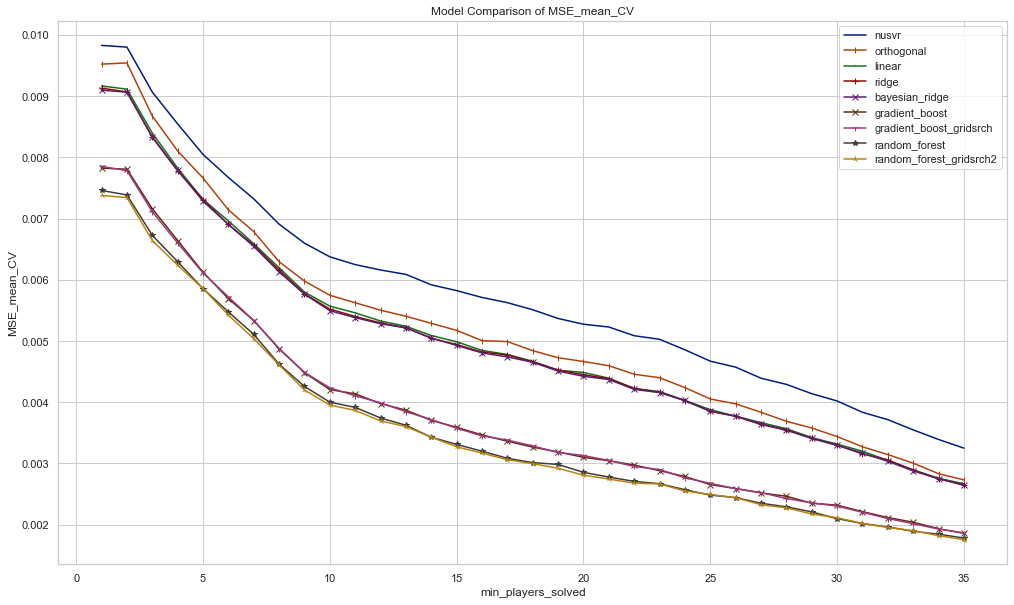

In [767]:
plt.figure(figsize=(17, 10))
plt.title('Model Comparison of MSE_mean_CV')
m1 = plt.plot(linear.min_players_solved, nusvr['MSE_mean_CV'], label='nusvr')
m2 = plt.plot(linear.min_players_solved, omp['MSE_mean_CV'], marker="|", label='orthogonal')
m3 = plt.plot(linear.min_players_solved, linear['MSE_mean_CV'], marker=",", label='linear')
m4 = plt.plot(linear.min_players_solved, ridge['MSE_mean_CV'], marker="+", label='ridge')
m5 = plt.plot(linear.min_players_solved, bayesian_ridge['MSE_mean_CV'], marker="x", label='bayesian_ridge')
m6 = plt.plot(linear.min_players_solved, gbr['MSE_mean_CV'], marker="x", label='gradient_boost')
m7 = plt.plot(linear.min_players_solved, gbrgs['MSE_mean_CV'], marker="1", label='gradient_boost_gridsrch')
m8 = plt.plot(linear.min_players_solved, rfr['MSE_mean_CV'], marker="*", label='random_forest')
# m9 = plt.plot(linear.min_players_solved, rfrgs['MSE_mean_CV'], marker="2", label='random_forest_gridsrch')
m10 = plt.plot(linear.min_players_solved, rfrgs2['MSE_mean_CV'], marker="2", label='random_forest_gridsrch2')
plt.xlabel('min_players_solved')
plt.ylabel('MSE_mean_CV')
plt.legend(loc='upper right')
plt.show()

With mean squared error, Nu Support Vector Regression comes out on top - which for this metric makes it the worst performer. Orthogonal Matching Pursuit was much better, but still the 2nd worst model. Linear, Ridge, and Bayesian models produced similar results, accounting for the tight grouping just underneath the orthogonal plot. Results for Gradient Boosting with and without GridSearchCV are almost identical, making them nearly indistinguishable. Plots for these two models appear slightly above the random forest models. Finally, Random Forest proves to dominate the models, with the GridSearchCV version edging out its non-hypertuned counterpart. As the threshold for min_players_solved increases, mean squared error decreases across all models. As previously mentioned, this demonstrates the effect that sample size has on the quality of estimates.

### R-Squared

Now, we evaluate and compare R-squared across the models tested. Plots are below, with analysis following.

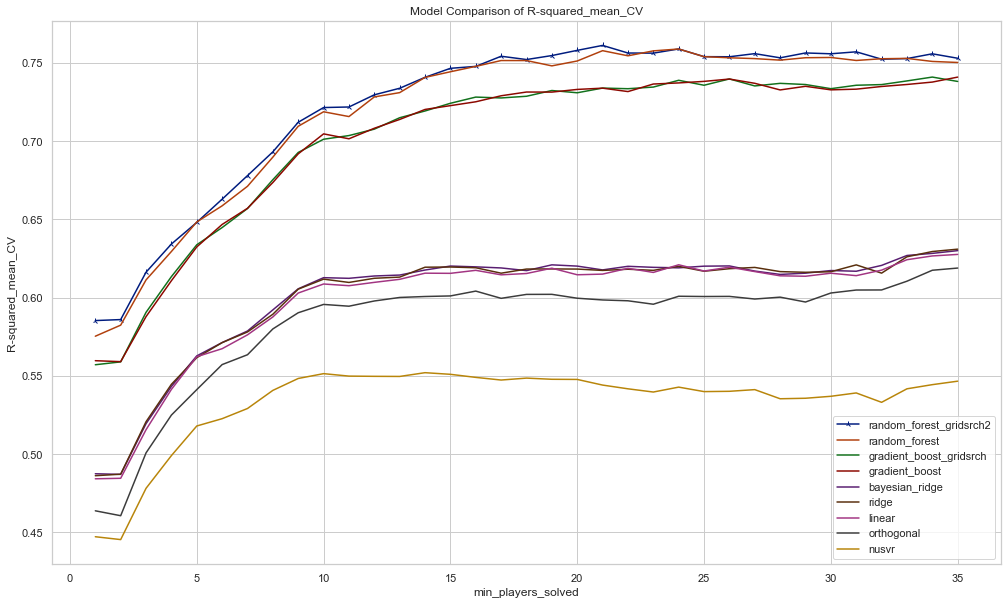

In [768]:
plt.figure(figsize=(17, 10))
plt.title('Model Comparison of R-squared_mean_CV')
m10 = plt.plot(linear.min_players_solved, rfrgs2['R-squared_mean_CV'], marker="2", label='random_forest_gridsrch2')
# m1 = plt.plot(linear.min_players_solved, rfrgs['R-squared_mean_CV'], label='random_forest_gridsrch')
m2 = plt.plot(linear.min_players_solved, rfr['R-squared_mean_CV'], label='random_forest')
m3 = plt.plot(linear.min_players_solved, gbrgs['R-squared_mean_CV'], label='gradient_boost_gridsrch')
m4 = plt.plot(linear.min_players_solved, gbr['R-squared_mean_CV'], label='gradient_boost')
m5 = plt.plot(linear.min_players_solved, bayesian_ridge['R-squared_mean_CV'], label='bayesian_ridge')
m6 = plt.plot(linear.min_players_solved, ridge['R-squared_mean_CV'], label='ridge')
m7 = plt.plot(linear.min_players_solved, linear['R-squared_mean_CV'], label='linear')
m8 = plt.plot(linear.min_players_solved, omp['R-squared_mean_CV'], label='orthogonal')
m9 = plt.plot(linear.min_players_solved, nusvr['R-squared_mean_CV'], label='nusvr')
plt.xlabel('min_players_solved')
plt.ylabel('R-squared_mean_CV')
plt.legend(loc='lower right')
plt.show()

In terms of ranking model performance, there are no surprises here. Again, Random Forests outclassed the competition. However, the GridSearchCV version shows more separation here than when comparing MSE values, and is therefore declared the overall best model. Again, the Gradient Boosting models performed well; and again, the difference between the default and hypertuned models is negligible. The Linear, Ridge, and Bayesian Ridge models again produced similar results, but the plot indicates that R-Squared values for the linear model were slightly lower than the ridge models. Orthogonal Matching Pursuit ranked the same as it did with mean squared error, but here it shows the most substantial improvement in the last 5 iterations (where players_solved increases from 30 to 35). NuSVR again ranks at the bottom, but unlike the other models and unlike its MSE metrics, performance began to decline at a min_players_solved threshold of 14, and did not recover until the last few iterations.

# Conclusion

RoboZZle was much more popular 11 years ago when the game and website were first launched. I began playing almost 3 years ago, when the game's popularity had already been declining for several years. I once spoke with Igor Ostrovsky (the creator of RoboZZle) on a phone call about 2 years ago, to discuss ways to update the website, revitalize the game, renew the interest of experienced players, and attract new players. He expressed his appreciation for my interest, but with his busy work schedule, could not justify setting aside any time to implement improvements. He said that it was a niche game, and regardless of how much work was put into development, would likely remain a niche game. Whether this is true or not either remains to be seen, or will never be known. Yet, even an analysis from a niche game can provide insight for broader applications. Creating a model that predicts popularity applies to any entity or platform that captures a measure of user enjoyment. The most obvious parallel is with YouTube. Robozzle does not pay its puzzle designers, but if they did, this research would provide insight on which authors are most deserving of compensation, and how to derive an appropriate value for compensation. In the case with YouTube, there is an active business model which already does this. How effective is their model? Would the Random Forest Regressor in this research be more effective than the model that YouTube employs? Some data scientist at YouTube might be able to answer these particular questions, which could serve as a basis for further research. YouTube does take into consideration many more elements of the user experience than RoboZZle. For example, YouTube tracks the duration of a view (how long a viewer watched a video).  On the other hand, RoboZZle has no available data on how much time a player spends solving a puzzle.  Furthermore, there is no data from players who have attempted a puzzle, but failed to solve it. Of course, a 'niche' game like this isn't generating revenue, so it's impractical to expect the site to have more advanced metrics. In general, whether it's a household 'product' like YouTube, or a lesser known game like RoboZZle, any entity interested in the public reception of their product or service would benefit from developing reliable methods of estimating popularity.